In [1]:
#!pip install lightgbm
#!pip install catboost
#!pip install scikit-learn --upgrade
#!pip install sktime --user
#!pip install shap --user

#print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [2]:
#LOADS LIBRARIES
import os
import sys
import warnings
warnings.simplefilter('ignore')
import pickle
#import dill as pickle

import numpy as np
import pandas as pd
import math

import time 
import datetime
from dateutil.relativedelta import relativedelta

In [3]:
import sklearn

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, KBinsDiscretizer
#import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [4]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import uniform
from random import randint
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,\
                            precision_recall_curve, roc_auc_score, balanced_accuracy_score, log_loss

from sklearn.model_selection import cross_val_score, learning_curve, validation_curve,\
                                    TimeSeriesSplit, RandomizedSearchCV, GridSearchCV, StratifiedKFold,\
                                    train_test_split, KFold, cross_validate

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interactive, interact, fixed
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()

import plotly.graph_objs as go
import shap
import itertools 

In [7]:
DIR_OUTPUTS = r'C:\Users\willi\Documents\EJERCICIOS\TRADING\outputs/'

# Develops analitycal model simulation

In [8]:
df_analysis = pd.read_pickle(DIR_OUTPUTS + 'df_spx500_5m_s1.pkl')

print(df_analysis.shape)
print('\n')
print(min(df_analysis['Datetime']))
print(max(df_analysis['Datetime']))

(1263, 54)


2021-12-23 12:30:00
2022-03-04 16:00:00


In [9]:
#Defines the time window to do analisys
order_datetime = datetime.datetime(2022,2,28,12,45)
start_datetime = order_datetime - relativedelta(days=20)
end_datetime = order_datetime + relativedelta(days=1.5)

In [10]:

def simulation(order_datetime, start_datetime, end_datetime):
    
    ################################################################################################
    #Gets the simulation data
    df_analysis_01a = df_analysis[(df_analysis['Datetime']>=start_datetime)
                                 &(df_analysis['Datetime']<=end_datetime)]

    df_analysis_01a = df_analysis_01a.reset_index(drop=True)

    df_analysis_01 = df_analysis_01a.copy()
    ################################################################################################



    ################################################################################################
    # Defines variables
    # Here all cateorical columns
    ls_cat_variables = [
                     ]

    # Here all numerical columns

    ls_ss1pcavars = ['ss1_close_c1','ss1_close_c2','ss1_close_c3']
    ls_ss1vars2 = ['ss1_close_' + str(x) for x in range(8,0,-1) ]
    ls_slopevars = ['slope_close_' + str(x) for x in range(0,4) ]

    ls_ss1_macdh = ['ss1_macdh_c1','ss1_macdh_c2','ss1_macdh_c3']
    ls_ss1_macdh2 = ['ss1_macdh_' + str(x) for x in range(8,0,-1) ]
    ls_slopes_macdh = ['slope_macdh_' + str(x) for x in range(0,4) ]

    ls_ss1_vols = ['ss1_vols_c1','ss1_vols_c2','ss1_vols_c3']
    ls_ss1_vols2 = ['ss1_vols_' + str(x) for x in range(8,0,-1) ]
    ls_slopes_vols = ['slope_vols_' + str(x) for x in range(0,4) ]

    ls_num_variables = ls_slopevars + ls_ss1vars2 + ls_ss1pcavars +\
                        ls_slopes_vols + ls_ss1_vols2 + ls_ss1_vols + \
                        ls_slopes_macdh + ls_ss1_macdh2 + ls_ss1_macdh
                        # ls_slopes_macd + ls_ss80_macd2 + ls_ss80_macd + \

    # Here all key columnsdf_analysis
    ls_keys = [
        'Datetime',
    ]

    Target = 'target_order_bin' #specify the column containing the target
    Target_desc = 'target_order'

    df_analysis_01[ls_num_variables] = df_analysis_01[ls_num_variables].astype(float)
    ################################################################################################



    ################################################################################################
    #Codes the target to better understanding for the model

    df_target_coded =  df_analysis_01[Target_desc].value_counts(dropna=False).reset_index()
    df_target_coded =  df_target_coded.sort_values(['index']).reset_index(drop=True)
    df_target_coded = df_target_coded.reset_index()
    df_target_coded['level_0'] = df_target_coded['level_0'].apply(lambda x: str(x).zfill(2))


    df_target_coded = df_target_coded.rename(columns={Target_desc:'Frequency',
                                                'level_0':Target_desc + '_coded',
                                                'index':Target_desc})

    df_analysis_02a = pd.merge(df_analysis_01,
                             df_target_coded[[Target_desc, Target_desc + '_coded']],
                             on = [Target_desc],
                             how='left').copy()


    # SAVING POINT
    df_target_coded.to_pickle(DIR_OUTPUTS + 'df_periodo_cancelacion_coded' + '.pkl')
    ################################################################################################



    #############################################################################################################################
    #Filters the data to a sales model
    df_analysis_02 = df_analysis_02a[(df_analysis_02a['target_order'].isin(['NULL'])==False)].copy()

    #Filters the data to a TRAIN test
    df_analysis_train_01 = df_analysis_02a[(df_analysis_02a['Datetime'] < order_datetime)
                                          &(df_analysis_02a['target_order'].isin(['NULL'])==False)].copy()

    #Filters the data to a TEST test
    df_analysis_test_01 = df_analysis_02a[(df_analysis_02a['Datetime'] >= order_datetime)].copy()
    #############################################################################################################################



    #############################################################################################################################
    #Defines X vector to all process

    X_train = df_analysis_train_01[ls_cat_variables + ls_num_variables]

    y_train = df_analysis_train_01[Target_desc + '_coded']

    X_test = df_analysis_test_01[ls_cat_variables + ls_num_variables]

    y_test = df_analysis_test_01[Target_desc + '_coded']
    #############################################################################################################################


    #############################################################################################################################
    # Creating a Stratified Cross folds for temporal data

    n_test = 2
    gap = 7

    n_splits = round(len(X_train)/n_test) - 1
    print('Number of splits for CV: ',n_splits)

    skf = TimeSeriesSplit(n_splits=n_splits)
    #############################################################################################################################



    #############################################################################################################################
    # RF MODEL CALIBRATION

    # Defines the column transformer
    rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_num_variables),
                                            ]) 

    #Prepares model pip

    rf_pip = Pipeline([('preprocessing', rf_transformer),
                        ('model', RandomForestClassifier())])

    # grid of model hyperparameters to be optimised, you can look for parameters definitions in the model link
    rf_params = {'model__n_estimators': [100], #Number of trees
                  'model__criterion': ['gini'],
                  'model__max_depth': [7],
                  'model__class_weight':['balanced'],
                  'model__random_state': [0],
                 }


    # We launch a grid seach: testing different hyperparameters on a cross validation 
    # and select the ones that optimises the performance of the mode 

    rf_search = RandomizedSearchCV(rf_pip, rf_params, 
                                    n_iter=10, # This is the number of parameters to test , you can choose more
                                    n_jobs=-1, # Number of jobs /threads
                                    verbose=2, 
                                    cv=skf, # the stratified crossvalidation that we created before
                                    scoring='balanced_accuracy')

    def f_rf_search():
        rf_search.fit(X_train, y_train)

        print('Best parameters :', rf_search.best_params_)
        print('Best score (balanced accuracy) :', rf_search.best_score_)

        return rf_search
    #############################################################################################################################



    #############################################################################################################################
    # Hold Predictions table

    # Selectiong winner model in the calibration program
    selected_model = 'RF'

    X_work = X_test
    y_work = y_test

    ls_target_info = ['Datetime','Close','target_order','target_close','target_difference','target_date','target_date_diff']


    if selected_model == 'RF':
        winner_model = f_rf_search()
    if selected_model == 'EX':
        winner_model = f_ex_search()
    if selected_model == 'clf':
        winner_model = f_clf()
    if selected_model == 'lgbm':
        winner_model = f_lgbm_search()

    df_datainfo = df_analysis_02a.iloc[X_work.index,:]
    df_datainfo = df_datainfo[ls_target_info]
    df_datainfo = df_datainfo.reset_index(drop=True)

    #########################################################################
    y_prob = winner_model.predict_proba(X_work)

    df_model_probs = pd.DataFrame(y_prob)
    df_model_probs = df_model_probs.reset_index(drop=True)
    #########################################################################


    #########################################################################
    y_pred = winner_model.predict(X_work)

    df_model_preds = df_datainfo
    df_model_preds = df_model_preds.reset_index(drop=True)
    #########################################################################


    #######################################################################################################
    df_model_preds['target_order_coded'] = y_work.reset_index(drop=True)
    df_model_preds.loc[df_model_preds['target_order_coded'].isnull(),'target_order_coded']='NULL'

    df_model_preds['y_pred'] = y_pred

    dc_renamecols = {
        'target_order_coded': 'y_pred',
        'target_order': 'prediction_order',
        }

    df_prediction_coded = df_target_coded.rename(columns=dc_renamecols)


    df_model_preds = pd.merge(df_model_preds,
                          df_prediction_coded[['y_pred','prediction_order']],
                          on = ['y_pred'],
                          how='left'
                          ).copy()

    df_model_preds = pd.concat([df_model_preds,df_model_probs],axis=1)

    try:
        df_model_preds['max_prob'] = df_model_preds[[0,1,2,3]].max(axis=1)
    except:
        df_model_preds['max_prob'] = df_model_preds[[0,1,2]].max(axis=1)
    #######################################################################################################


    ##############################################################################################################################
    # Confusion Matrix

    ls_model_matches = []

    for i in range(1,len(df_model_preds)+1):
        #df_model_preds_01 = df_model_preds[df_model_preds['max_prob']>=0.42].copy()
        df_model_preds_01 = df_model_preds.iloc[:i,].copy()


        df_summary = df_model_preds_01.groupby(['target_order','prediction_order'] ).agg(
            orders_quantity = ('max_prob','count'),
            median_time = ('target_date_diff','median')
        )

        df_summary = df_summary.reset_index()

        True_buys = sum(df_summary[(df_summary['target_order'].isin(['BUY','BUY2']))&(df_summary['prediction_order'].isin(['BUY','BUY2']))]['orders_quantity'])
        True_sells = sum(df_summary[(df_summary['target_order'].isin(['SELL','SELL2']))&(df_summary['prediction_order'].isin(['SELL','SELL2']))]['orders_quantity'])
        Total_orders = sum(df_summary['orders_quantity'])

        pp_model_match = (True_buys + True_sells) / Total_orders
        ls_model_matches.append(pp_model_match)

    df_summary.sort_values(['orders_quantity'],ascending=[False])

    print(df_analysis_02.shape)
    print(min(df_analysis_02['Datetime']))
    print(max(df_analysis_02['Datetime']))

    print(df_model_preds.shape)
    print(min(df_model_preds['Datetime']))
    print(max(df_model_preds['Datetime']))

    print('% Model match: ', pp_model_match)

    plt.scatter(range(0,len(ls_model_matches)), ls_model_matches)
    plt.show()
    ##############################################################################################################################


    ##############################################################################################################################
    # Consolidates simulation results
    df_sim_results = df_model_preds.iloc[0:2,:]
    df_sim_results['Model match'] = pp_model_match
    #df_sim_results
    ##############################################################################################################################

    return df_sim_results

Number of splits for CV:  55
Fitting 55 folds for each of 1 candidates, totalling 55 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7454545454545455
(156, 55)
2022-02-22 09:30:00
2022-03-01 15:45:00
(43, 15)
2022-02-28 11:45:00
2022-03-01 15:45:00
% Model match:  0.4883720930232558


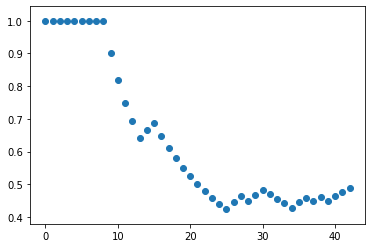

Datetime        Close target_order  target_close  \
0 2022-02-28 11:45:00  4380.479980         SELL   4356.740234   
1 2022-02-28 12:00:00  4356.740234         SELL   4322.439941   

   target_difference         target_date  target_date_diff target_order_coded  \
0              -24.0 2022-02-28 12:00:00              15.0                 02   
1              -34.0 2022-02-28 14:00:00             120.0                 02   

  y_pred prediction_order         0         1         2         3  max_prob  \
0     02             SELL  0.191146  0.119735  0.535777  0.153342  0.535777   
1     02             SELL  0.269650  0.030000  0.449656  0.250695  0.449656   

   Model match  
0     0.488372  
1     0.488372

In [11]:
#Defines the time window to do analisys
order_datetime = datetime.datetime(2022,2,28,11,45)
start_datetime = order_datetime - relativedelta(days=7)
end_datetime = order_datetime + relativedelta(days=1.5)

simulation(order_datetime, start_datetime, end_datetime)

In [12]:
ls_valdates = np.unique(np.array(df_analysis['date'].tolist())).tolist()
ls_valdates

ls_seldates = [x for x in ls_valdates if (x >= datetime.datetime(2022,2,1).date())&(x <= datetime.datetime(2022,2,15).date())]

ls_inits_dates = []
for dt in ls_seldates:
    dtt = datetime.datetime(dt.year,dt.month,dt.day,9,45)
    ls_inits_dates.append(dtt)

ls_inits_dates

[datetime.datetime(2022, 2, 1, 9, 45),
 datetime.datetime(2022, 2, 2, 9, 45),
 datetime.datetime(2022, 2, 3, 9, 45),
 datetime.datetime(2022, 2, 4, 9, 45),
 datetime.datetime(2022, 2, 7, 9, 45),
 datetime.datetime(2022, 2, 8, 9, 45),
 datetime.datetime(2022, 2, 9, 9, 45),
 datetime.datetime(2022, 2, 10, 9, 45),
 datetime.datetime(2022, 2, 11, 9, 45),
 datetime.datetime(2022, 2, 14, 9, 45),
 datetime.datetime(2022, 2, 15, 9, 45)]

In [13]:

#ls_inits_dates = [datetime.datetime(2022,2,22,9,45)]


for init_date in ls_inits_dates:
    j = init_date
    testing_dates = [init_date]

    for i in range(0,24):
        gen_date = init_date + relativedelta(minutes=15)
        testing_dates.append(gen_date)
        init_date = gen_date
        
    if j==ls_inits_dates[0]:
        testing_dates_01 = testing_dates
    else:
        testing_dates_01 = testing_dates_01 + testing_dates
    
testing_dates_01

[datetime.datetime(2022, 2, 1, 9, 45),
 datetime.datetime(2022, 2, 1, 10, 0),
 datetime.datetime(2022, 2, 1, 10, 15),
 datetime.datetime(2022, 2, 1, 10, 30),
 datetime.datetime(2022, 2, 1, 10, 45),
 datetime.datetime(2022, 2, 1, 11, 0),
 datetime.datetime(2022, 2, 1, 11, 15),
 datetime.datetime(2022, 2, 1, 11, 30),
 datetime.datetime(2022, 2, 1, 11, 45),
 datetime.datetime(2022, 2, 1, 12, 0),
 datetime.datetime(2022, 2, 1, 12, 15),
 datetime.datetime(2022, 2, 1, 12, 30),
 datetime.datetime(2022, 2, 1, 12, 45),
 datetime.datetime(2022, 2, 1, 13, 0),
 datetime.datetime(2022, 2, 1, 13, 15),
 datetime.datetime(2022, 2, 1, 13, 30),
 datetime.datetime(2022, 2, 1, 13, 45),
 datetime.datetime(2022, 2, 1, 14, 0),
 datetime.datetime(2022, 2, 1, 14, 15),
 datetime.datetime(2022, 2, 1, 14, 30),
 datetime.datetime(2022, 2, 1, 14, 45),
 datetime.datetime(2022, 2, 1, 15, 0),
 datetime.datetime(2022, 2, 1, 15, 15),
 datetime.datetime(2022, 2, 1, 15, 30),
 datetime.datetime(2022, 2, 1, 15, 45),
 dateti

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(155, 55)
2022-01-26 09:45:00
2022-02-02 15:45:00
(51, 15)
2022-02-01 09:45:00
2022-02-02 15:45:00
% Model match:  0.3333333333333333


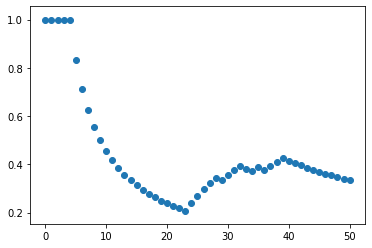

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5588235294117647
(154, 55)
2022-01-26 10:00:00
2022-02-02 15:45:00
(50, 15)
2022-02-01 10:00:00
2022-02-02 15:45:00
% Model match:  0.26


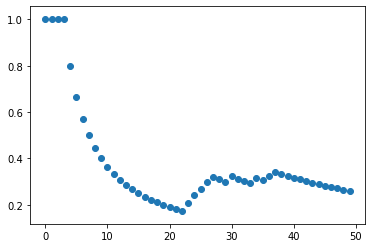

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(153, 55)
2022-01-26 10:15:00
2022-02-02 15:45:00
(49, 15)
2022-02-01 10:15:00
2022-02-02 15:45:00
% Model match:  0.3469387755102041


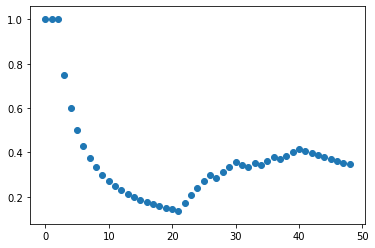

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(152, 55)
2022-01-26 10:30:00
2022-02-02 15:45:00
(48, 15)
2022-02-01 10:30:00
2022-02-02 15:45:00
% Model match:  0.4583333333333333


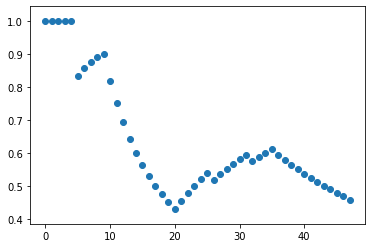

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(151, 55)
2022-01-26 10:45:00
2022-02-02 15:45:00
(47, 15)
2022-02-01 10:45:00
2022-02-02 15:45:00
% Model match:  0.3404255319148936


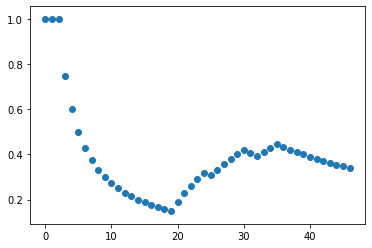

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(150, 55)
2022-01-26 11:00:00
2022-02-02 15:45:00
(46, 15)
2022-02-01 11:00:00
2022-02-02 15:45:00
% Model match:  0.32608695652173914


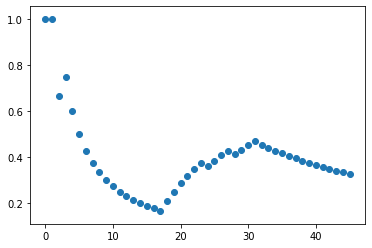

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(149, 55)
2022-01-26 11:15:00
2022-02-02 15:45:00
(45, 15)
2022-02-01 11:15:00
2022-02-02 15:45:00
% Model match:  0.28888888888888886


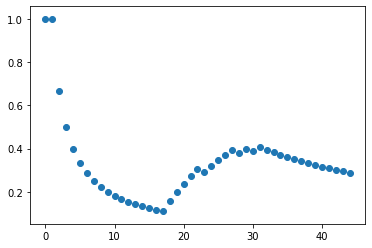

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(148, 55)
2022-01-26 11:30:00
2022-02-02 15:45:00
(44, 15)
2022-02-01 11:30:00
2022-02-02 15:45:00
% Model match:  0.4772727272727273


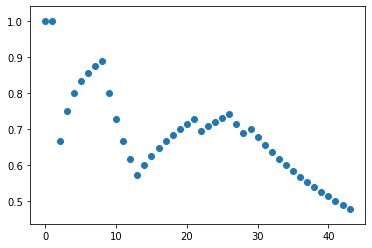

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6764705882352942
(147, 55)
2022-01-26 11:45:00
2022-02-02 15:45:00
(43, 15)
2022-02-01 11:45:00
2022-02-02 15:45:00
% Model match:  0.4883720930232558


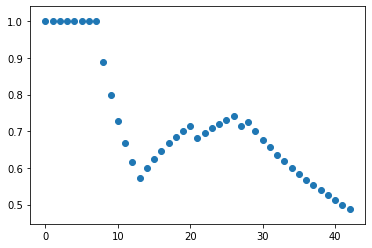

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(146, 55)
2022-01-26 12:00:00
2022-02-02 15:45:00
(42, 15)
2022-02-01 12:00:00
2022-02-02 15:45:00
% Model match:  0.5238095238095238


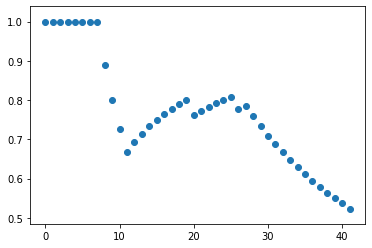

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(145, 55)
2022-01-26 12:15:00
2022-02-02 15:45:00
(41, 15)
2022-02-01 12:15:00
2022-02-02 15:45:00
% Model match:  0.6097560975609756


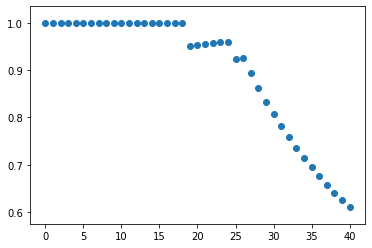

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(144, 55)
2022-01-26 12:30:00
2022-02-02 15:45:00
(40, 15)
2022-02-01 12:30:00
2022-02-02 15:45:00
% Model match:  0.6


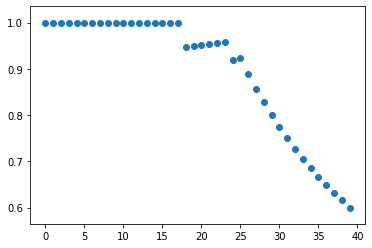

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(143, 55)
2022-01-26 12:45:00
2022-02-02 15:45:00
(39, 15)
2022-02-01 12:45:00
2022-02-02 15:45:00
% Model match:  0.5897435897435898


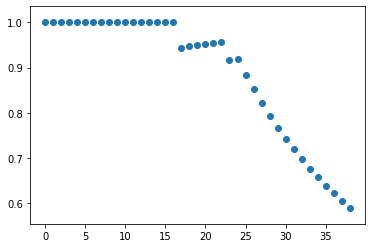

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(142, 55)
2022-01-26 13:00:00
2022-02-02 15:45:00
(38, 15)
2022-02-01 13:00:00
2022-02-02 15:45:00
% Model match:  0.5789473684210527


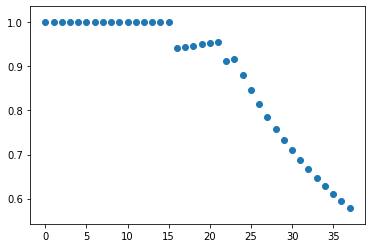

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(141, 55)
2022-01-26 13:15:00
2022-02-02 15:45:00
(37, 15)
2022-02-01 13:15:00
2022-02-02 15:45:00
% Model match:  0.5675675675675675


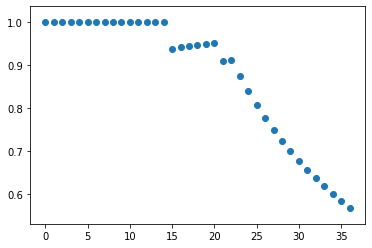

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(140, 55)
2022-01-26 13:30:00
2022-02-02 15:45:00
(36, 15)
2022-02-01 13:30:00
2022-02-02 15:45:00
% Model match:  0.5555555555555556


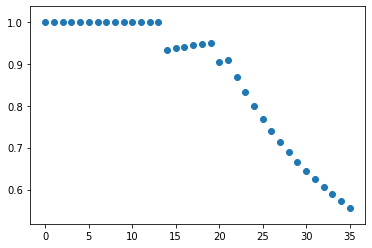

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(139, 55)
2022-01-26 13:45:00
2022-02-02 15:45:00
(35, 15)
2022-02-01 13:45:00
2022-02-02 15:45:00
% Model match:  0.5428571428571428


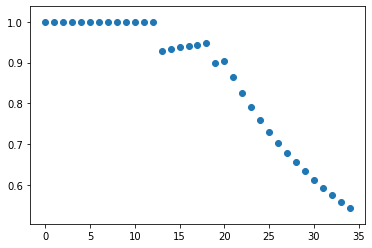

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(138, 55)
2022-01-26 14:00:00
2022-02-02 15:45:00
(34, 15)
2022-02-01 14:00:00
2022-02-02 15:45:00
% Model match:  0.5294117647058824


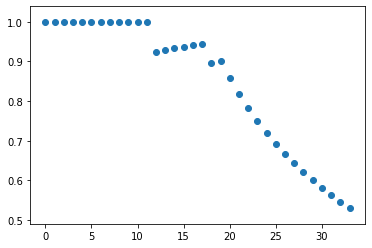

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(137, 55)
2022-01-26 14:15:00
2022-02-02 15:45:00
(33, 15)
2022-02-01 14:15:00
2022-02-02 15:45:00
% Model match:  0.5151515151515151


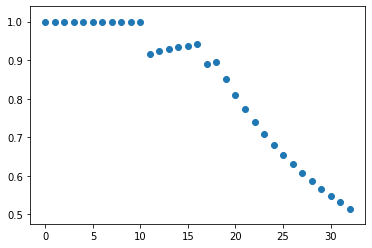

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(136, 55)
2022-01-26 14:30:00
2022-02-02 15:45:00
(32, 15)
2022-02-01 14:30:00
2022-02-02 15:45:00
% Model match:  0.5


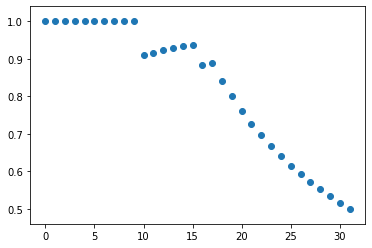

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7058823529411765
(135, 55)
2022-01-26 14:45:00
2022-02-02 15:45:00
(31, 15)
2022-02-01 14:45:00
2022-02-02 15:45:00
% Model match:  0.4838709677419355


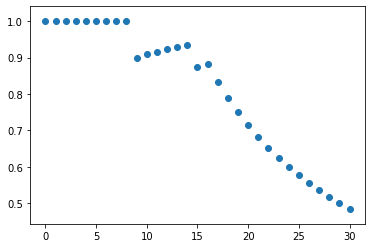

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(134, 55)
2022-01-26 15:00:00
2022-02-02 15:45:00
(30, 15)
2022-02-01 15:00:00
2022-02-02 15:45:00
% Model match:  0.4666666666666667


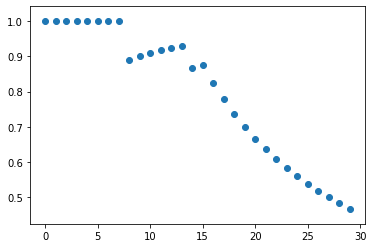

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.696078431372549
(133, 55)
2022-01-26 15:15:00
2022-02-02 15:45:00
(29, 15)
2022-02-01 15:15:00
2022-02-02 15:45:00
% Model match:  0.4482758620689655


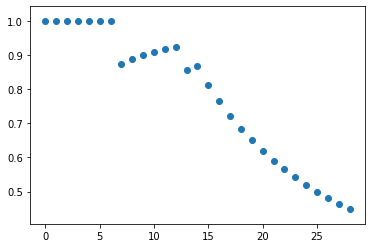

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5980392156862745
(132, 55)
2022-01-26 15:30:00
2022-02-02 15:45:00
(28, 15)
2022-02-01 15:30:00
2022-02-02 15:45:00
% Model match:  0.42857142857142855


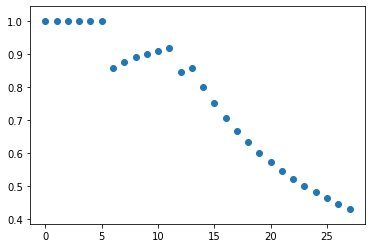

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7156862745098039
(131, 55)
2022-01-26 15:45:00
2022-02-02 15:45:00
(27, 15)
2022-02-01 15:45:00
2022-02-02 15:45:00
% Model match:  0.4074074074074074


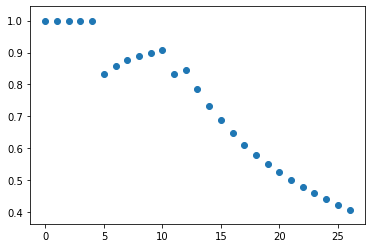

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.696078431372549
(155, 55)
2022-01-27 09:45:00
2022-02-03 15:45:00
(51, 15)
2022-02-02 09:45:00
2022-02-03 15:45:00
% Model match:  0.45098039215686275


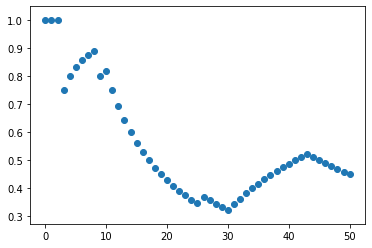

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(154, 55)
2022-01-27 10:00:00
2022-02-03 15:45:00
(50, 15)
2022-02-02 10:00:00
2022-02-03 15:45:00
% Model match:  0.44


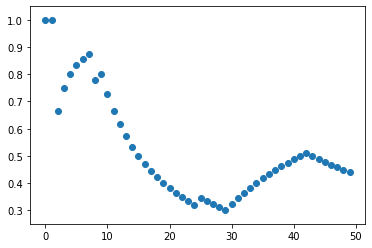

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7058823529411765
(153, 55)
2022-01-27 10:15:00
2022-02-03 15:45:00
(49, 15)
2022-02-02 10:15:00
2022-02-03 15:45:00
% Model match:  0.42857142857142855


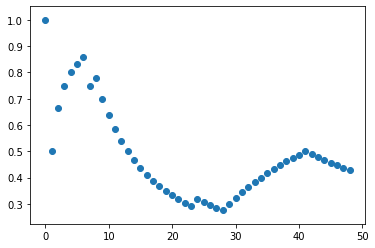

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(152, 55)
2022-01-27 10:30:00
2022-02-03 15:45:00
(48, 15)
2022-02-02 10:30:00
2022-02-03 15:45:00
% Model match:  0.3958333333333333


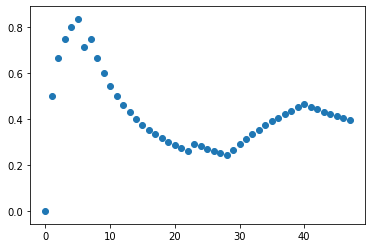

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(151, 55)
2022-01-27 10:45:00
2022-02-03 15:45:00
(47, 15)
2022-02-02 10:45:00
2022-02-03 15:45:00
% Model match:  0.3617021276595745


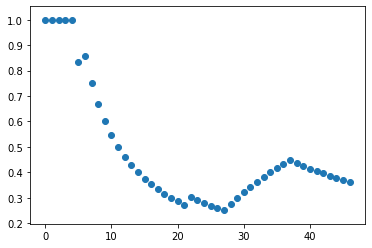

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(150, 55)
2022-01-27 11:00:00
2022-02-03 15:45:00
(46, 15)
2022-02-02 11:00:00
2022-02-03 15:45:00
% Model match:  0.391304347826087


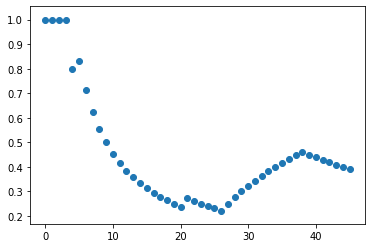

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(149, 55)
2022-01-27 11:15:00
2022-02-03 15:45:00
(45, 15)
2022-02-02 11:15:00
2022-02-03 15:45:00
% Model match:  0.3111111111111111


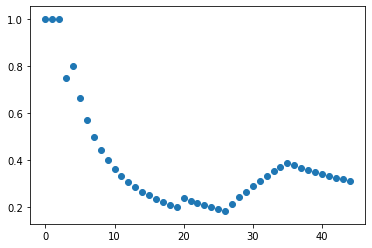

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(148, 55)
2022-01-27 11:30:00
2022-02-03 15:45:00
(44, 15)
2022-02-02 11:30:00
2022-02-03 15:45:00
% Model match:  0.25


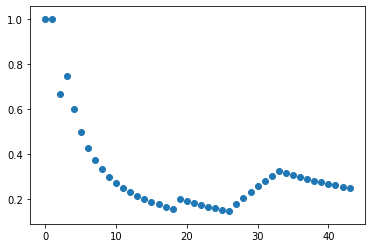

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6862745098039216
(147, 55)
2022-01-27 11:45:00
2022-02-03 15:45:00
(43, 15)
2022-02-02 11:45:00
2022-02-03 15:45:00
% Model match:  0.27906976744186046


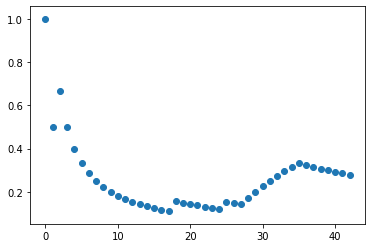

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(146, 55)
2022-01-27 12:00:00
2022-02-03 15:45:00
(42, 15)
2022-02-02 12:00:00
2022-02-03 15:45:00
% Model match:  0.16666666666666666


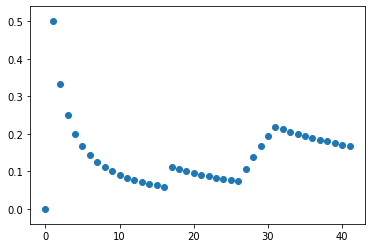

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(145, 55)
2022-01-27 12:15:00
2022-02-03 15:45:00
(41, 15)
2022-02-02 12:15:00
2022-02-03 15:45:00
% Model match:  0.21951219512195122


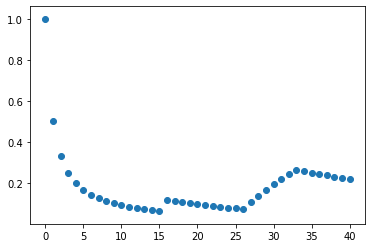

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5980392156862745
(144, 55)
2022-01-27 12:30:00
2022-02-03 15:45:00
(40, 15)
2022-02-02 12:30:00
2022-02-03 15:45:00
% Model match:  0.175


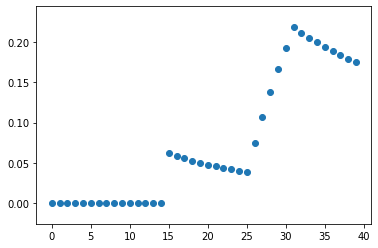

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(143, 55)
2022-01-27 12:45:00
2022-02-03 15:45:00
(39, 15)
2022-02-02 12:45:00
2022-02-03 15:45:00
% Model match:  0.15384615384615385


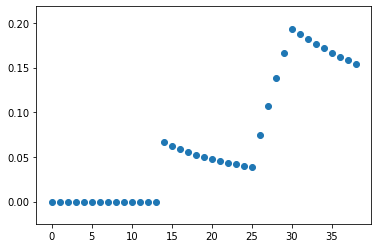

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(142, 55)
2022-01-27 13:00:00
2022-02-03 15:45:00
(38, 15)
2022-02-02 13:00:00
2022-02-03 15:45:00
% Model match:  0.23684210526315788


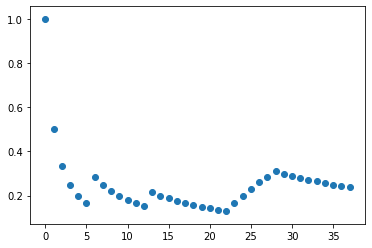

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(141, 55)
2022-01-27 13:15:00
2022-02-03 15:45:00
(37, 15)
2022-02-02 13:15:00
2022-02-03 15:45:00
% Model match:  0.10810810810810811


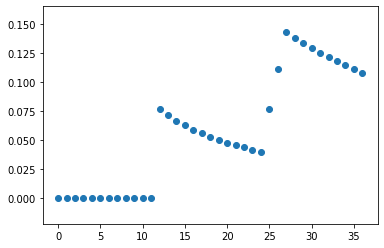

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(140, 55)
2022-01-27 13:30:00
2022-02-03 15:45:00
(36, 15)
2022-02-02 13:30:00
2022-02-03 15:45:00
% Model match:  0.3055555555555556


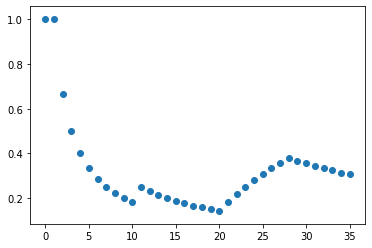

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(139, 55)
2022-01-27 13:45:00
2022-02-03 15:45:00
(35, 15)
2022-02-02 13:45:00
2022-02-03 15:45:00
% Model match:  0.4


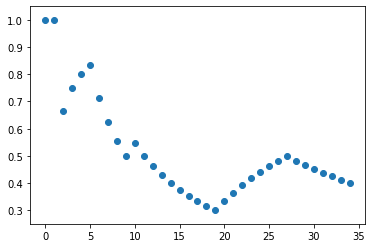

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5882352941176471
(138, 55)
2022-01-27 14:00:00
2022-02-03 15:45:00
(34, 15)
2022-02-02 14:00:00
2022-02-03 15:45:00
% Model match:  0.35294117647058826


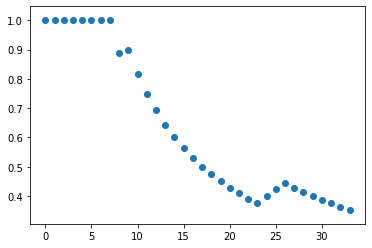

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(137, 55)
2022-01-27 14:15:00
2022-02-03 15:45:00
(33, 15)
2022-02-02 14:15:00
2022-02-03 15:45:00
% Model match:  0.24242424242424243


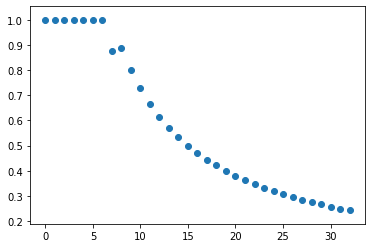

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5588235294117647
(136, 55)
2022-01-27 14:30:00
2022-02-03 15:45:00
(32, 15)
2022-02-02 14:30:00
2022-02-03 15:45:00
% Model match:  0.21875


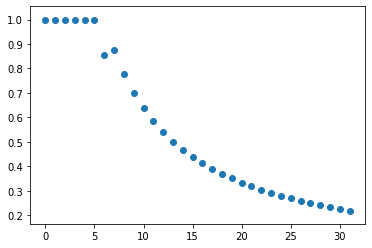

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(135, 55)
2022-01-27 14:45:00
2022-02-03 15:45:00
(31, 15)
2022-02-02 14:45:00
2022-02-03 15:45:00
% Model match:  0.3870967741935484


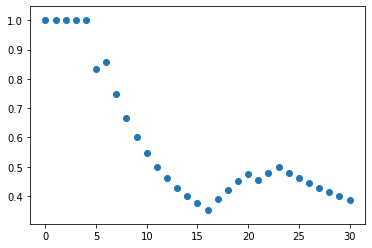

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(134, 55)
2022-01-27 15:00:00
2022-02-03 15:45:00
(30, 15)
2022-02-02 15:00:00
2022-02-03 15:45:00
% Model match:  0.13333333333333333


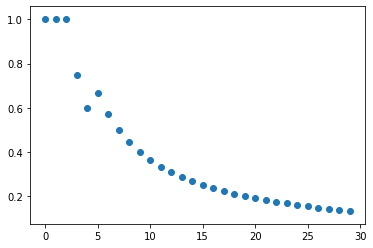

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.696078431372549
(133, 55)
2022-01-27 15:15:00
2022-02-03 15:45:00
(29, 15)
2022-02-02 15:15:00
2022-02-03 15:45:00
% Model match:  0.41379310344827586


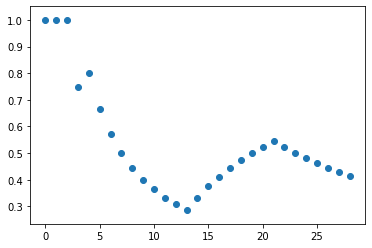

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5980392156862745
(132, 55)
2022-01-27 15:30:00
2022-02-03 15:45:00
(28, 15)
2022-02-02 15:30:00
2022-02-03 15:45:00
% Model match:  0.32142857142857145


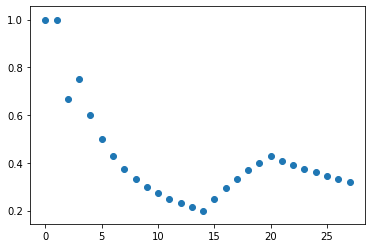

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.696078431372549
(131, 55)
2022-01-27 15:45:00
2022-02-03 15:45:00
(27, 15)
2022-02-02 15:45:00
2022-02-03 15:45:00
% Model match:  0.4074074074074074


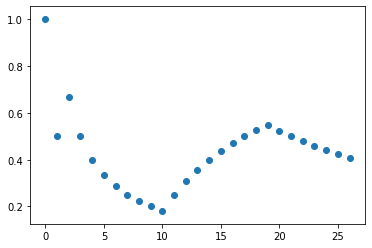

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(155, 55)
2022-01-28 09:45:00
2022-02-04 15:45:00
(51, 15)
2022-02-03 09:45:00
2022-02-04 15:45:00
% Model match:  0.23529411764705882


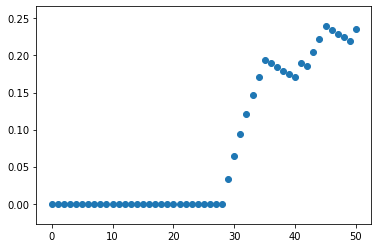

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5784313725490197
(154, 55)
2022-01-28 10:00:00
2022-02-04 15:45:00
(50, 15)
2022-02-03 10:00:00
2022-02-04 15:45:00
% Model match:  0.2


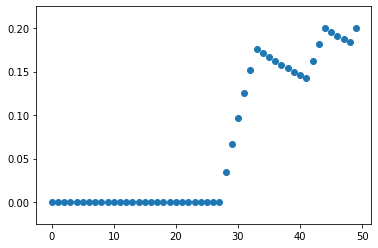

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(153, 55)
2022-01-28 10:15:00
2022-02-04 15:45:00
(49, 15)
2022-02-03 10:15:00
2022-02-04 15:45:00
% Model match:  0.2653061224489796


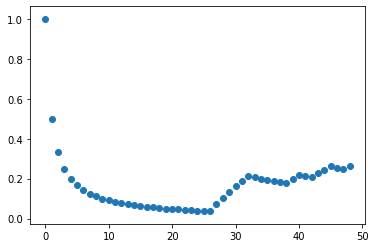

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5882352941176471
(152, 55)
2022-01-28 10:30:00
2022-02-04 15:45:00
(48, 15)
2022-02-03 10:30:00
2022-02-04 15:45:00
% Model match:  0.2708333333333333


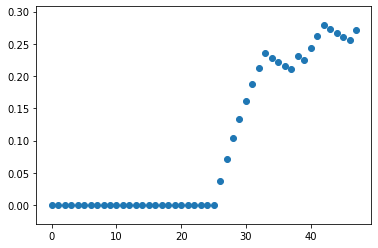

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6764705882352942
(151, 55)
2022-01-28 10:45:00
2022-02-04 15:45:00
(47, 15)
2022-02-03 10:45:00
2022-02-04 15:45:00
% Model match:  0.5106382978723404


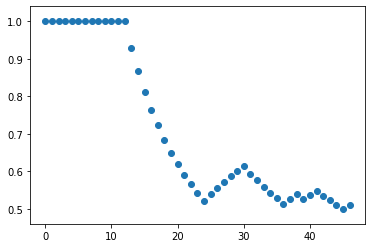

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(150, 55)
2022-01-28 11:00:00
2022-02-04 15:45:00
(46, 15)
2022-02-03 11:00:00
2022-02-04 15:45:00
% Model match:  0.5869565217391305


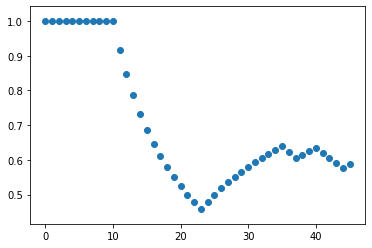

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6862745098039216
(149, 55)
2022-01-28 11:15:00
2022-02-04 15:45:00
(45, 15)
2022-02-03 11:15:00
2022-02-04 15:45:00
% Model match:  0.6222222222222222


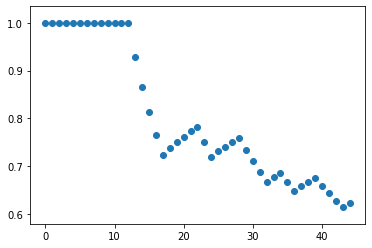

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(148, 55)
2022-01-28 11:30:00
2022-02-04 15:45:00
(44, 15)
2022-02-03 11:30:00
2022-02-04 15:45:00
% Model match:  0.5681818181818182


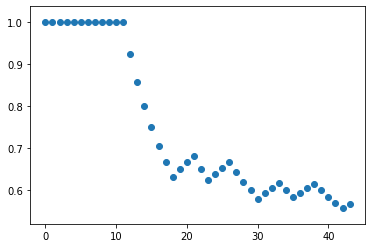

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(147, 55)
2022-01-28 11:45:00
2022-02-04 15:45:00
(43, 15)
2022-02-03 11:45:00
2022-02-04 15:45:00
% Model match:  0.4418604651162791


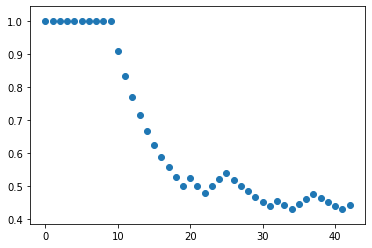

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(146, 55)
2022-01-28 12:00:00
2022-02-04 15:45:00
(42, 15)
2022-02-03 12:00:00
2022-02-04 15:45:00
% Model match:  0.6428571428571429


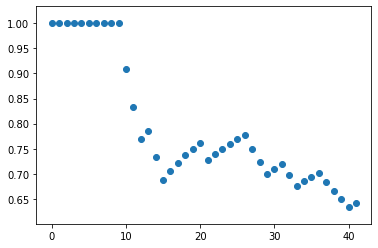

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(145, 55)
2022-01-28 12:15:00
2022-02-04 15:45:00
(41, 15)
2022-02-03 12:15:00
2022-02-04 15:45:00
% Model match:  0.6585365853658537


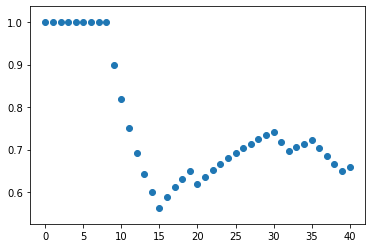

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(144, 55)
2022-01-28 12:30:00
2022-02-04 15:45:00
(40, 15)
2022-02-03 12:30:00
2022-02-04 15:45:00
% Model match:  0.625


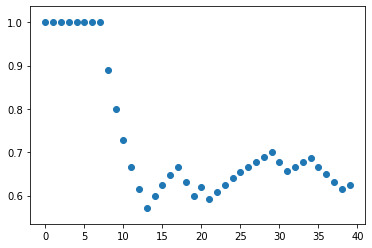

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(143, 55)
2022-01-28 12:45:00
2022-02-04 15:45:00
(39, 15)
2022-02-03 12:45:00
2022-02-04 15:45:00
% Model match:  0.5897435897435898


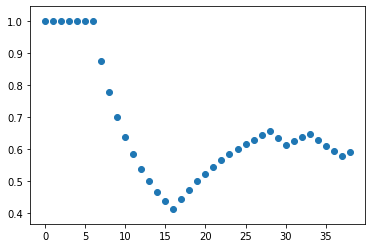

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(142, 55)
2022-01-28 13:00:00
2022-02-04 15:45:00
(38, 15)
2022-02-03 13:00:00
2022-02-04 15:45:00
% Model match:  0.5789473684210527


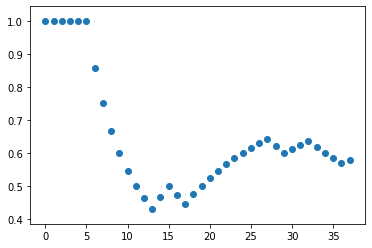

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(141, 55)
2022-01-28 13:15:00
2022-02-04 15:45:00
(37, 15)
2022-02-03 13:15:00
2022-02-04 15:45:00
% Model match:  0.6486486486486487


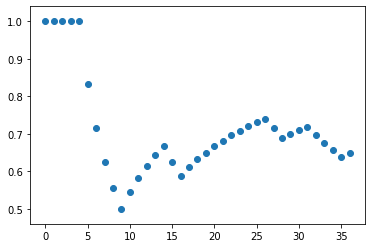

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(140, 55)
2022-01-28 13:30:00
2022-02-04 15:45:00
(36, 15)
2022-02-03 13:30:00
2022-02-04 15:45:00
% Model match:  0.5555555555555556


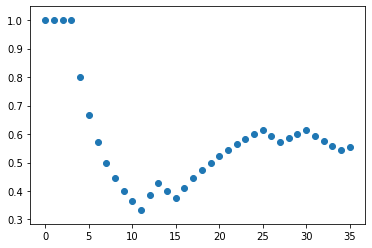

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5882352941176471
(139, 55)
2022-01-28 13:45:00
2022-02-04 15:45:00
(35, 15)
2022-02-03 13:45:00
2022-02-04 15:45:00
% Model match:  0.5142857142857142


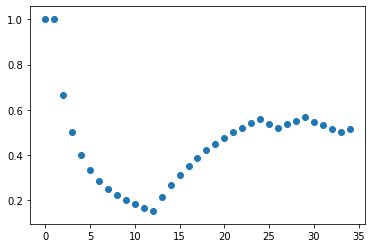

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(138, 55)
2022-01-28 14:00:00
2022-02-04 15:45:00
(34, 15)
2022-02-03 14:00:00
2022-02-04 15:45:00
% Model match:  0.5


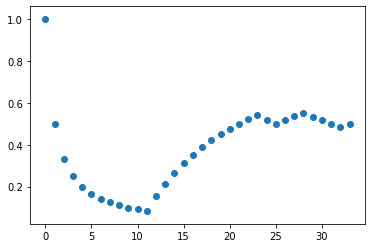

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(137, 55)
2022-01-28 14:15:00
2022-02-04 15:45:00
(33, 15)
2022-02-03 14:15:00
2022-02-04 15:45:00
% Model match:  0.5454545454545454


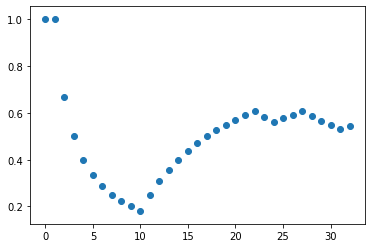

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5784313725490197
(136, 55)
2022-01-28 14:30:00
2022-02-04 15:45:00
(32, 15)
2022-02-03 14:30:00
2022-02-04 15:45:00
% Model match:  0.53125


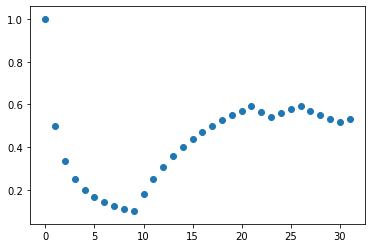

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5980392156862745
(135, 55)
2022-01-28 14:45:00
2022-02-04 15:45:00
(31, 15)
2022-02-03 14:45:00
2022-02-04 15:45:00
% Model match:  0.6129032258064516


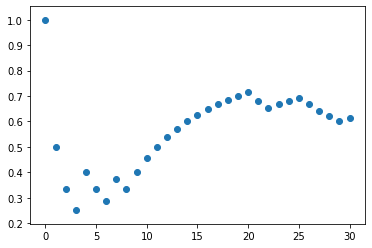

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5588235294117647
(134, 55)
2022-01-28 15:00:00
2022-02-04 15:45:00
(30, 15)
2022-02-03 15:00:00
2022-02-04 15:45:00
% Model match:  0.6666666666666666


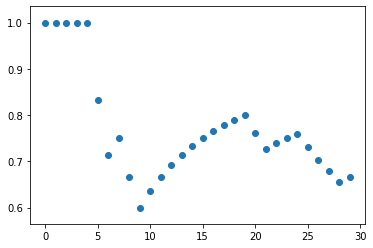

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5980392156862745
(133, 55)
2022-01-28 15:15:00
2022-02-04 15:45:00
(29, 15)
2022-02-03 15:15:00
2022-02-04 15:45:00
% Model match:  0.6896551724137931


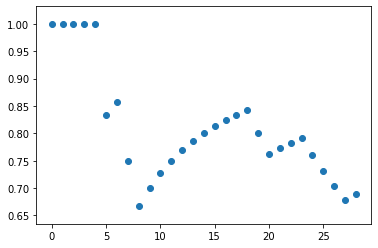

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5784313725490197
(132, 55)
2022-01-28 15:30:00
2022-02-04 15:45:00
(28, 15)
2022-02-03 15:30:00
2022-02-04 15:45:00
% Model match:  0.6428571428571429


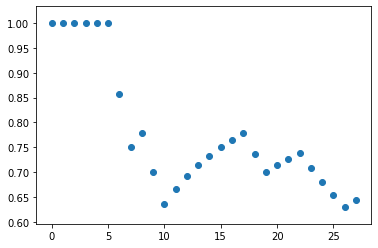

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(131, 55)
2022-01-28 15:45:00
2022-02-04 15:45:00
(27, 15)
2022-02-03 15:45:00
2022-02-04 15:45:00
% Model match:  0.4444444444444444


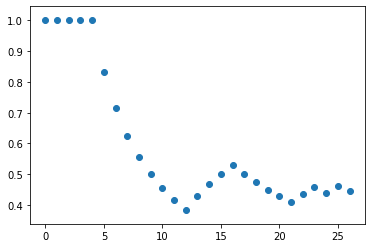

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5686274509803921
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(25, 15)
2022-02-04 09:45:00
2022-02-04 15:45:00
% Model match:  0.44


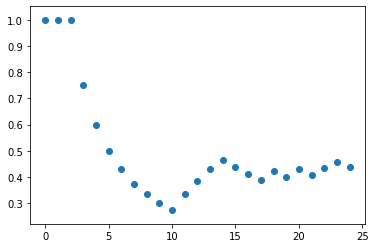

Number of splits for CV:  52
Fitting 52 folds for each of 1 candidates, totalling 52 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6057692307692307
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(24, 15)
2022-02-04 10:00:00
2022-02-04 15:45:00
% Model match:  0.4166666666666667


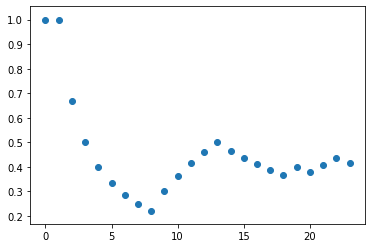

Number of splits for CV:  53
Fitting 53 folds for each of 1 candidates, totalling 53 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6037735849056604
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(23, 15)
2022-02-04 10:15:00
2022-02-04 15:45:00
% Model match:  0.30434782608695654


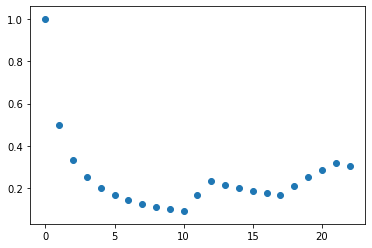

Number of splits for CV:  53
Fitting 53 folds for each of 1 candidates, totalling 53 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6132075471698113
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(22, 15)
2022-02-04 10:30:00
2022-02-04 15:45:00
% Model match:  0.2727272727272727


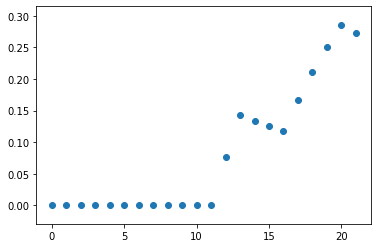

Number of splits for CV:  53
Fitting 53 folds for each of 1 candidates, totalling 53 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5754716981132075
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(21, 15)
2022-02-04 10:45:00
2022-02-04 15:45:00
% Model match:  0.3333333333333333


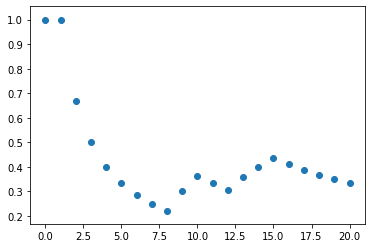

Number of splits for CV:  54
Fitting 54 folds for each of 1 candidates, totalling 54 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6018518518518519
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(20, 15)
2022-02-04 11:00:00
2022-02-04 15:45:00
% Model match:  0.55


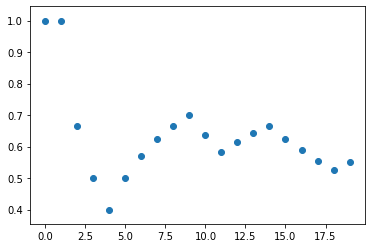

Number of splits for CV:  55
Fitting 55 folds for each of 1 candidates, totalling 55 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6181818181818182
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(19, 15)
2022-02-04 11:15:00
2022-02-04 15:45:00
% Model match:  0.5263157894736842


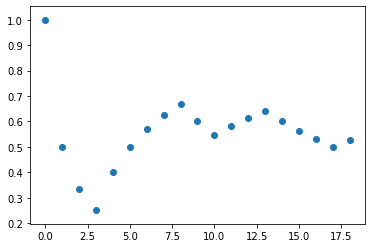

Number of splits for CV:  55
Fitting 55 folds for each of 1 candidates, totalling 55 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6090909090909091
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(18, 15)
2022-02-04 11:30:00
2022-02-04 15:45:00
% Model match:  0.6666666666666666


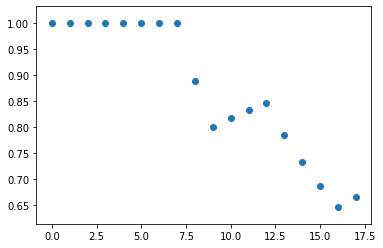

Number of splits for CV:  55
Fitting 55 folds for each of 1 candidates, totalling 55 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5818181818181818
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(17, 15)
2022-02-04 11:45:00
2022-02-04 15:45:00
% Model match:  0.6470588235294118


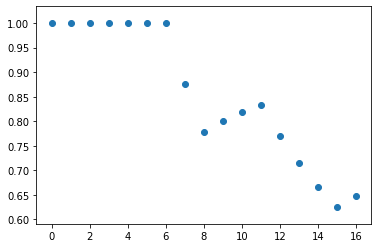

Number of splits for CV:  56
Fitting 56 folds for each of 1 candidates, totalling 56 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6160714285714286
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(16, 15)
2022-02-04 12:00:00
2022-02-04 15:45:00
% Model match:  0.625


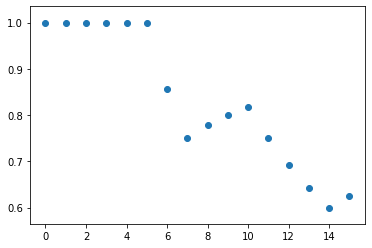

Number of splits for CV:  57
Fitting 57 folds for each of 1 candidates, totalling 57 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(15, 15)
2022-02-04 12:15:00
2022-02-04 15:45:00
% Model match:  0.6


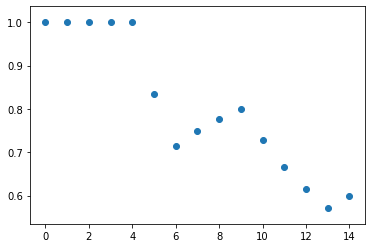

Number of splits for CV:  57
Fitting 57 folds for each of 1 candidates, totalling 57 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6228070175438597
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(14, 15)
2022-02-04 12:30:00
2022-02-04 15:45:00
% Model match:  0.5714285714285714


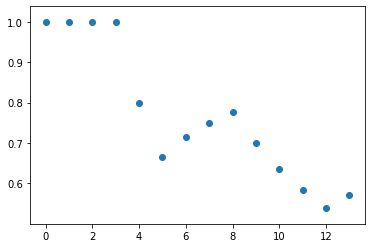

Number of splits for CV:  57
Fitting 57 folds for each of 1 candidates, totalling 57 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5964912280701754
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(13, 15)
2022-02-04 12:45:00
2022-02-04 15:45:00
% Model match:  0.5384615384615384


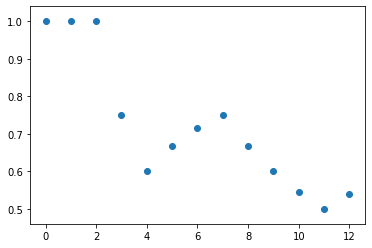

Number of splits for CV:  58
Fitting 58 folds for each of 1 candidates, totalling 58 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6293103448275862
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(12, 15)
2022-02-04 13:00:00
2022-02-04 15:45:00
% Model match:  0.5


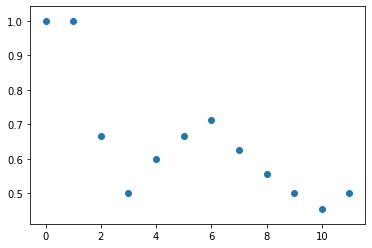

Number of splits for CV:  59
Fitting 59 folds for each of 1 candidates, totalling 59 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6949152542372882
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(11, 15)
2022-02-04 13:15:00
2022-02-04 15:45:00
% Model match:  0.45454545454545453


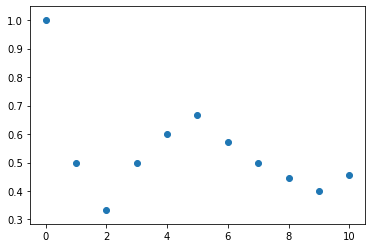

Number of splits for CV:  59
Fitting 59 folds for each of 1 candidates, totalling 59 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.635593220338983
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(10, 15)
2022-02-04 13:30:00
2022-02-04 15:45:00
% Model match:  0.4


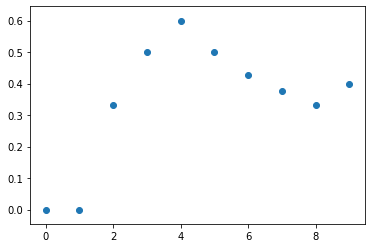

Number of splits for CV:  59
Fitting 59 folds for each of 1 candidates, totalling 59 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6016949152542372
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(9, 15)
2022-02-04 13:45:00
2022-02-04 15:45:00
% Model match:  0.4444444444444444


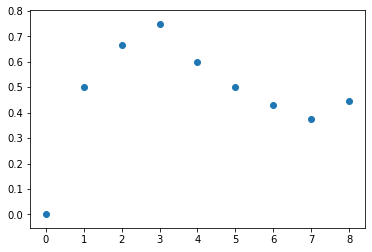

Number of splits for CV:  60
Fitting 60 folds for each of 1 candidates, totalling 60 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.625
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(8, 15)
2022-02-04 14:00:00
2022-02-04 15:45:00
% Model match:  0.25


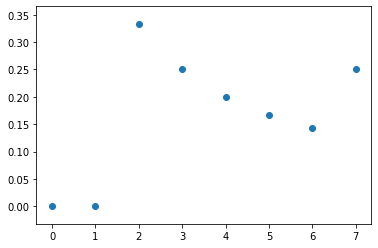

Number of splits for CV:  61
Fitting 61 folds for each of 1 candidates, totalling 61 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6557377049180327
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(7, 15)
2022-02-04 14:15:00
2022-02-04 15:45:00
% Model match:  0.42857142857142855


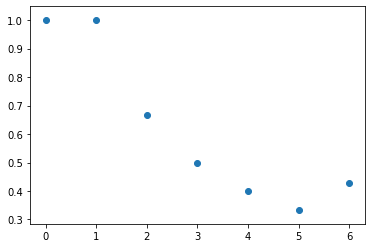

Number of splits for CV:  61
Fitting 61 folds for each of 1 candidates, totalling 61 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6147540983606558
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(6, 15)
2022-02-04 14:30:00
2022-02-04 15:45:00
% Model match:  0.3333333333333333


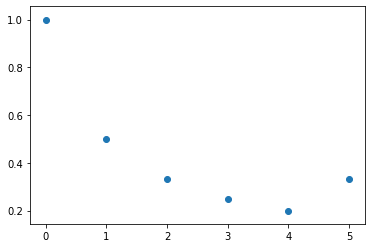

Number of splits for CV:  61
Fitting 61 folds for each of 1 candidates, totalling 61 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6065573770491803
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(5, 15)
2022-02-04 14:45:00
2022-02-04 15:45:00
% Model match:  0.2


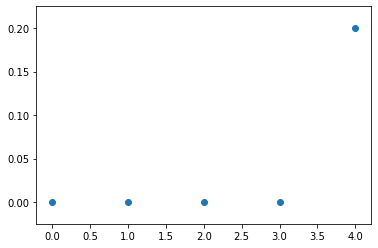

Number of splits for CV:  62
Fitting 62 folds for each of 1 candidates, totalling 62 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6129032258064516
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(4, 15)
2022-02-04 15:00:00
2022-02-04 15:45:00
% Model match:  0.25


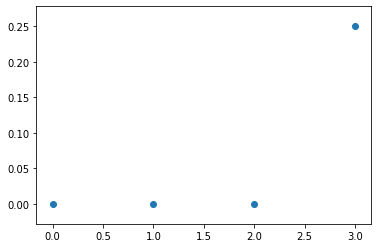

Number of splits for CV:  63
Fitting 63 folds for each of 1 candidates, totalling 63 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6507936507936508
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(3, 15)
2022-02-04 15:15:00
2022-02-04 15:45:00
% Model match:  0.6666666666666666


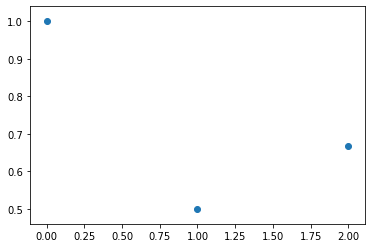

Number of splits for CV:  63
Fitting 63 folds for each of 1 candidates, totalling 63 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6031746031746031
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(2, 15)
2022-02-04 15:30:00
2022-02-04 15:45:00
% Model match:  1.0


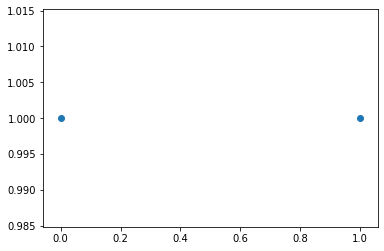

Number of splits for CV:  63
Fitting 63 folds for each of 1 candidates, totalling 63 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5952380952380952
(130, 55)
2022-01-31 09:30:00
2022-02-04 15:45:00
(1, 15)
2022-02-04 15:45:00
2022-02-04 15:45:00
% Model match:  0.0


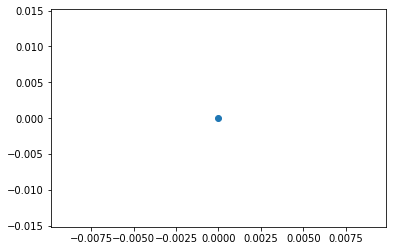

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(155, 55)
2022-02-01 09:45:00
2022-02-08 15:45:00
(51, 15)
2022-02-07 09:45:00
2022-02-08 15:45:00
% Model match:  0.7254901960784313


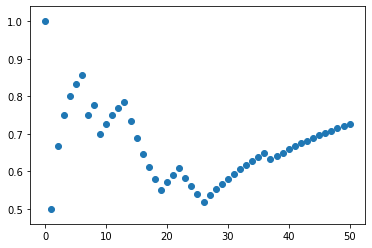

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(154, 55)
2022-02-01 10:00:00
2022-02-08 15:45:00
(50, 15)
2022-02-07 10:00:00
2022-02-08 15:45:00
% Model match:  0.62


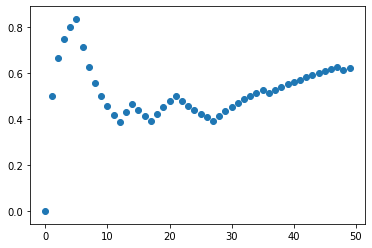

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(153, 55)
2022-02-01 10:15:00
2022-02-08 15:45:00
(49, 15)
2022-02-07 10:15:00
2022-02-08 15:45:00
% Model match:  0.673469387755102


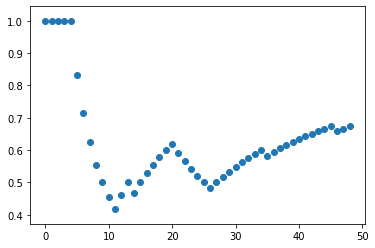

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(152, 55)
2022-02-01 10:30:00
2022-02-08 15:45:00
(48, 15)
2022-02-07 10:30:00
2022-02-08 15:45:00
% Model match:  0.6458333333333334


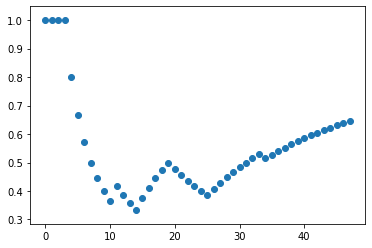

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7058823529411765
(151, 55)
2022-02-01 10:45:00
2022-02-08 15:45:00
(47, 15)
2022-02-07 10:45:00
2022-02-08 15:45:00
% Model match:  0.5957446808510638


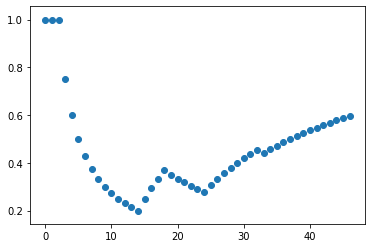

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(150, 55)
2022-02-01 11:00:00
2022-02-08 15:45:00
(46, 15)
2022-02-07 11:00:00
2022-02-08 15:45:00
% Model match:  0.6956521739130435


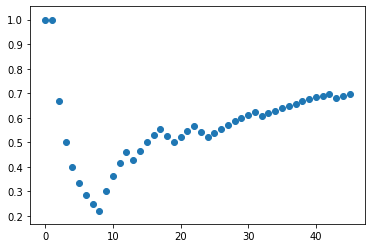

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7058823529411765
(149, 55)
2022-02-01 11:15:00
2022-02-08 15:45:00
(45, 15)
2022-02-07 11:15:00
2022-02-08 15:45:00
% Model match:  0.6666666666666666


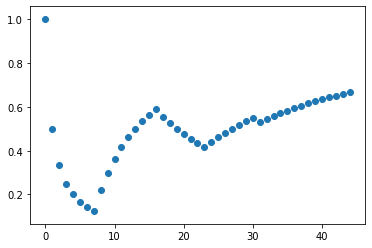

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(148, 55)
2022-02-01 11:30:00
2022-02-08 15:45:00
(44, 15)
2022-02-07 11:30:00
2022-02-08 15:45:00
% Model match:  0.6818181818181818


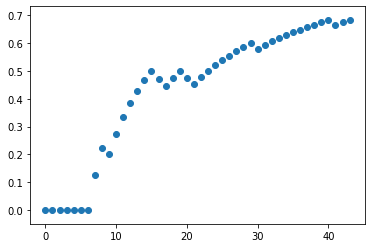

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.696078431372549
(147, 55)
2022-02-01 11:45:00
2022-02-08 15:45:00
(43, 15)
2022-02-07 11:45:00
2022-02-08 15:45:00
% Model match:  0.813953488372093


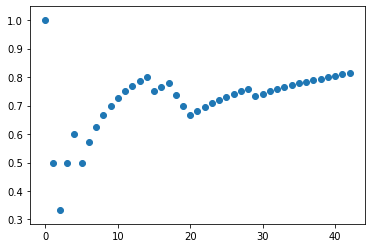

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5588235294117647
(146, 55)
2022-02-01 12:00:00
2022-02-08 15:45:00
(42, 15)
2022-02-07 12:00:00
2022-02-08 15:45:00
% Model match:  0.7857142857142857


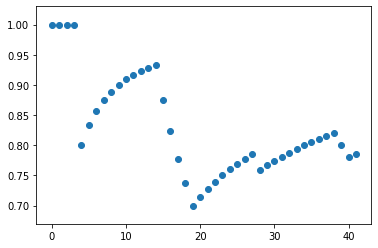

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(145, 55)
2022-02-01 12:15:00
2022-02-08 15:45:00
(41, 15)
2022-02-07 12:15:00
2022-02-08 15:45:00
% Model match:  0.8292682926829268


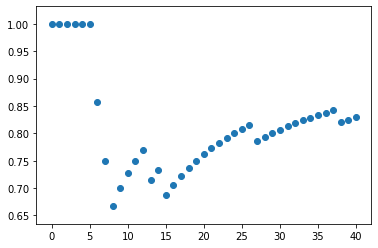

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5882352941176471
(144, 55)
2022-02-01 12:30:00
2022-02-08 15:45:00
(40, 15)
2022-02-07 12:30:00
2022-02-08 15:45:00
% Model match:  0.7


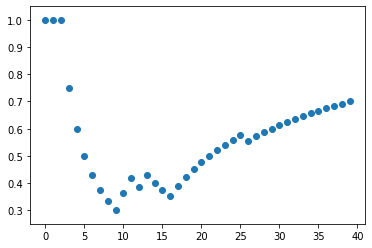

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(143, 55)
2022-02-01 12:45:00
2022-02-08 15:45:00
(39, 15)
2022-02-07 12:45:00
2022-02-08 15:45:00
% Model match:  0.6153846153846154


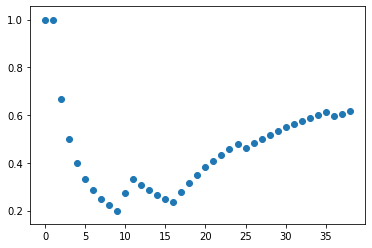

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5980392156862745
(142, 55)
2022-02-01 13:00:00
2022-02-08 15:45:00
(38, 15)
2022-02-07 13:00:00
2022-02-08 15:45:00
% Model match:  0.6052631578947368


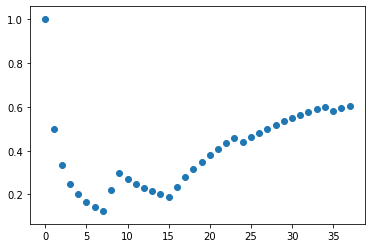

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6862745098039216
(141, 55)
2022-02-01 13:15:00
2022-02-08 15:45:00
(37, 15)
2022-02-07 13:15:00
2022-02-08 15:45:00
% Model match:  0.6486486486486487


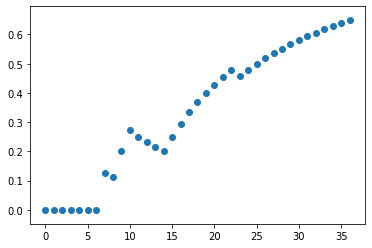

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5980392156862745
(140, 55)
2022-02-01 13:30:00
2022-02-08 15:45:00
(36, 15)
2022-02-07 13:30:00
2022-02-08 15:45:00
% Model match:  0.7222222222222222


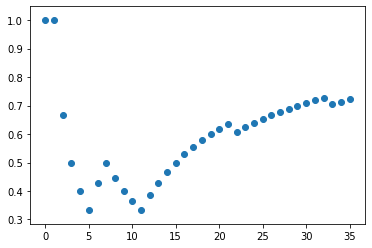

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(139, 55)
2022-02-01 13:45:00
2022-02-08 15:45:00
(35, 15)
2022-02-07 13:45:00
2022-02-08 15:45:00
% Model match:  0.8


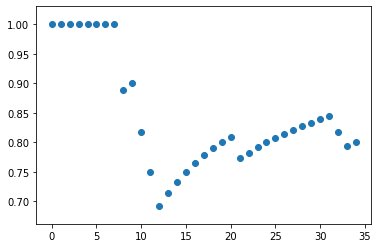

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5882352941176471
(138, 55)
2022-02-01 14:00:00
2022-02-08 15:45:00
(34, 15)
2022-02-07 14:00:00
2022-02-08 15:45:00
% Model match:  0.8235294117647058


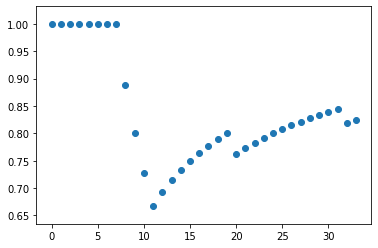

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(137, 55)
2022-02-01 14:15:00
2022-02-08 15:45:00
(33, 15)
2022-02-07 14:15:00
2022-02-08 15:45:00
% Model match:  0.7272727272727273


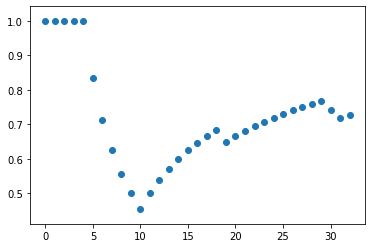

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5686274509803921
(136, 55)
2022-02-01 14:30:00
2022-02-08 15:45:00
(32, 15)
2022-02-07 14:30:00
2022-02-08 15:45:00
% Model match:  0.75


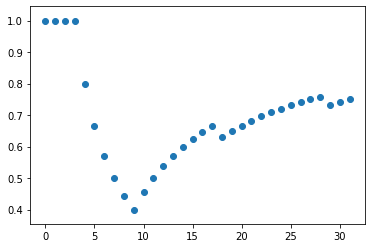

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(135, 55)
2022-02-01 14:45:00
2022-02-08 15:45:00
(31, 15)
2022-02-07 14:45:00
2022-02-08 15:45:00
% Model match:  0.6129032258064516


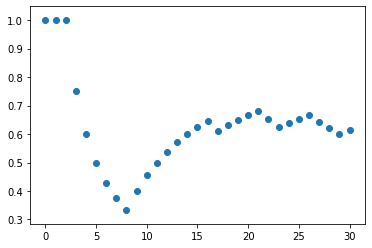

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(134, 55)
2022-02-01 15:00:00
2022-02-08 15:45:00
(30, 15)
2022-02-07 15:00:00
2022-02-08 15:45:00
% Model match:  0.36666666666666664


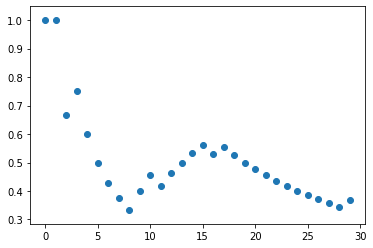

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(133, 55)
2022-02-01 15:15:00
2022-02-08 15:45:00
(29, 15)
2022-02-07 15:15:00
2022-02-08 15:45:00
% Model match:  0.3793103448275862


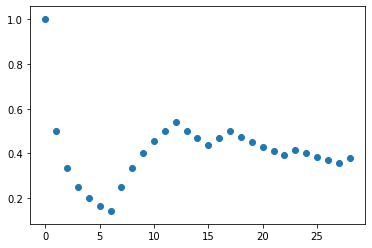

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5980392156862745
(132, 55)
2022-02-01 15:30:00
2022-02-08 15:45:00
(28, 15)
2022-02-07 15:30:00
2022-02-08 15:45:00
% Model match:  0.25


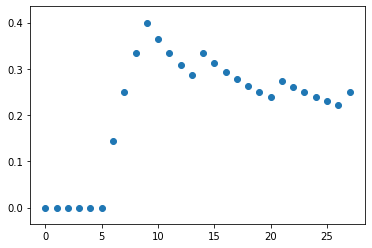

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(131, 55)
2022-02-01 15:45:00
2022-02-08 15:45:00
(27, 15)
2022-02-07 15:45:00
2022-02-08 15:45:00
% Model match:  0.5555555555555556


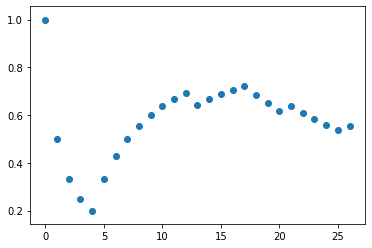

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(155, 55)
2022-02-02 09:45:00
2022-02-09 15:45:00
(51, 15)
2022-02-08 09:45:00
2022-02-09 15:45:00
% Model match:  0.5882352941176471


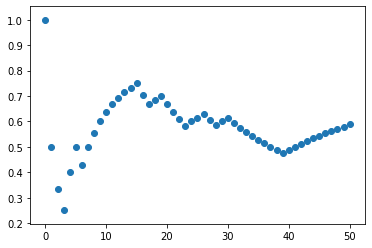

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5490196078431373
(154, 55)
2022-02-02 10:00:00
2022-02-09 15:45:00
(50, 15)
2022-02-08 10:00:00
2022-02-09 15:45:00
% Model match:  0.64


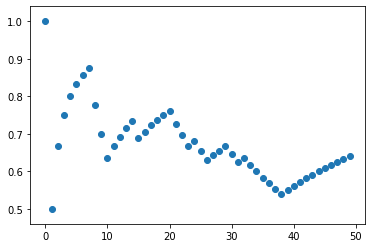

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(153, 55)
2022-02-02 10:15:00
2022-02-09 15:45:00
(49, 15)
2022-02-08 10:15:00
2022-02-09 15:45:00
% Model match:  0.5102040816326531


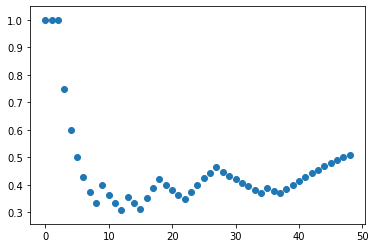

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5686274509803921
(152, 55)
2022-02-02 10:30:00
2022-02-09 15:45:00
(48, 15)
2022-02-08 10:30:00
2022-02-09 15:45:00
% Model match:  0.5416666666666666


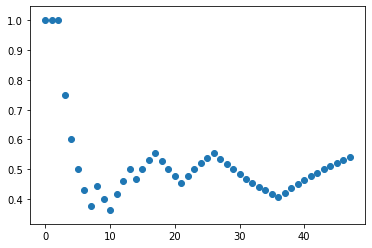

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(151, 55)
2022-02-02 10:45:00
2022-02-09 15:45:00
(47, 15)
2022-02-08 10:45:00
2022-02-09 15:45:00
% Model match:  0.6170212765957447


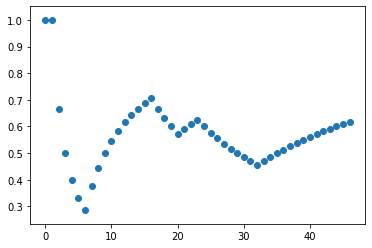

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5980392156862745
(150, 55)
2022-02-02 11:00:00
2022-02-09 15:45:00
(46, 15)
2022-02-08 11:00:00
2022-02-09 15:45:00
% Model match:  0.5217391304347826


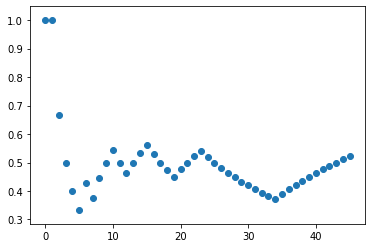

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(149, 55)
2022-02-02 11:15:00
2022-02-09 15:45:00
(45, 15)
2022-02-08 11:15:00
2022-02-09 15:45:00
% Model match:  0.5111111111111111


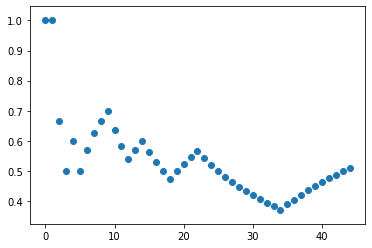

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(148, 55)
2022-02-02 11:30:00
2022-02-09 15:45:00
(44, 15)
2022-02-08 11:30:00
2022-02-09 15:45:00
% Model match:  0.4090909090909091


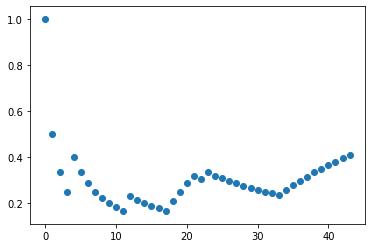

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(147, 55)
2022-02-02 11:45:00
2022-02-09 15:45:00
(43, 15)
2022-02-08 11:45:00
2022-02-09 15:45:00
% Model match:  0.6744186046511628


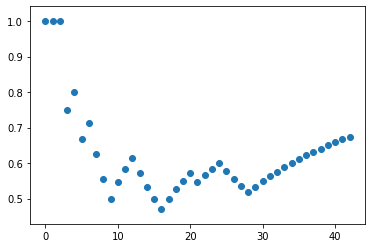

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5882352941176471
(146, 55)
2022-02-02 12:00:00
2022-02-09 15:45:00
(42, 15)
2022-02-08 12:00:00
2022-02-09 15:45:00
% Model match:  0.6666666666666666


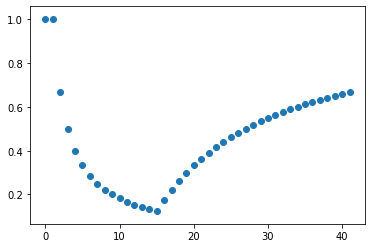

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(145, 55)
2022-02-02 12:15:00
2022-02-09 15:45:00
(41, 15)
2022-02-08 12:15:00
2022-02-09 15:45:00
% Model match:  0.6341463414634146


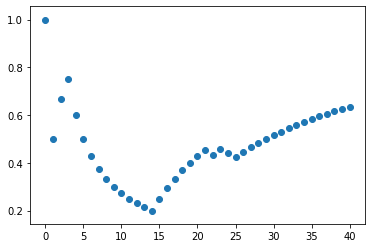

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5784313725490197
(144, 55)
2022-02-02 12:30:00
2022-02-09 15:45:00
(40, 15)
2022-02-08 12:30:00
2022-02-09 15:45:00
% Model match:  0.725


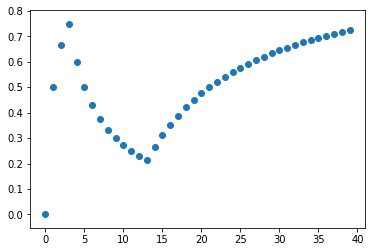

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(143, 55)
2022-02-02 12:45:00
2022-02-09 15:45:00
(39, 15)
2022-02-08 12:45:00
2022-02-09 15:45:00
% Model match:  0.6666666666666666


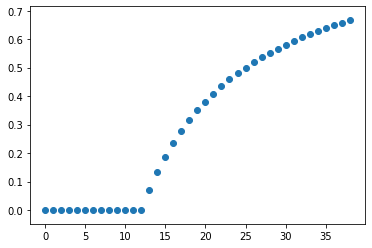

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5882352941176471
(142, 55)
2022-02-02 13:00:00
2022-02-09 15:45:00
(38, 15)
2022-02-08 13:00:00
2022-02-09 15:45:00
% Model match:  0.7368421052631579


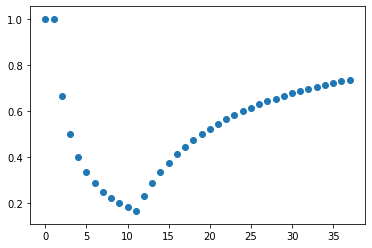

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6176470588235294
(141, 55)
2022-02-02 13:15:00
2022-02-09 15:45:00
(37, 15)
2022-02-08 13:15:00
2022-02-09 15:45:00
% Model match:  0.7837837837837838


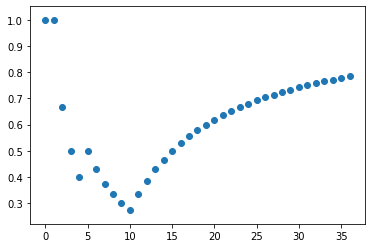

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5588235294117647
(140, 55)
2022-02-02 13:30:00
2022-02-09 15:45:00
(36, 15)
2022-02-08 13:30:00
2022-02-09 15:45:00
% Model match:  0.8611111111111112


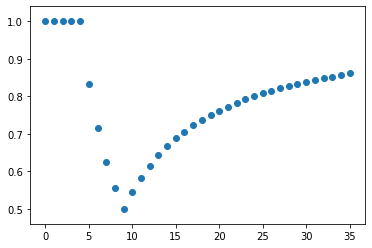

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5980392156862745
(139, 55)
2022-02-02 13:45:00
2022-02-09 15:45:00
(35, 15)
2022-02-08 13:45:00
2022-02-09 15:45:00
% Model match:  0.8571428571428571


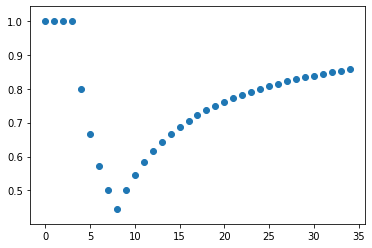

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(138, 55)
2022-02-02 14:00:00
2022-02-09 15:45:00
(34, 15)
2022-02-08 14:00:00
2022-02-09 15:45:00
% Model match:  0.8529411764705882


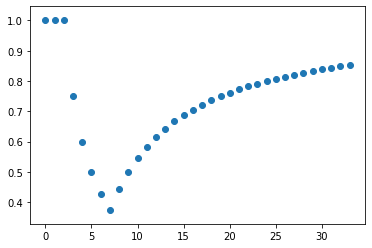

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5686274509803921
(137, 55)
2022-02-02 14:15:00
2022-02-09 15:45:00
(33, 15)
2022-02-08 14:15:00
2022-02-09 15:45:00
% Model match:  0.8787878787878788


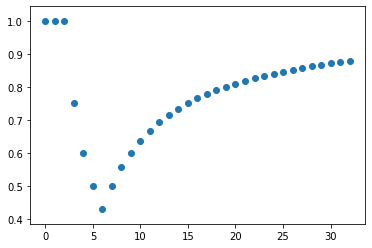

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5784313725490197
(136, 55)
2022-02-02 14:30:00
2022-02-09 15:45:00
(32, 15)
2022-02-08 14:30:00
2022-02-09 15:45:00
% Model match:  0.875


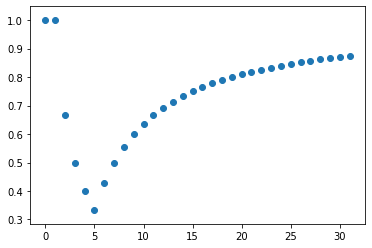

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5588235294117647
(135, 55)
2022-02-02 14:45:00
2022-02-09 15:45:00
(31, 15)
2022-02-08 14:45:00
2022-02-09 15:45:00
% Model match:  0.8709677419354839


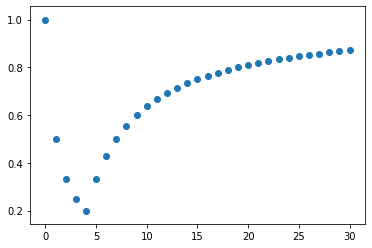

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5686274509803921
(134, 55)
2022-02-02 15:00:00
2022-02-09 15:45:00
(30, 15)
2022-02-08 15:00:00
2022-02-09 15:45:00
% Model match:  0.9333333333333333


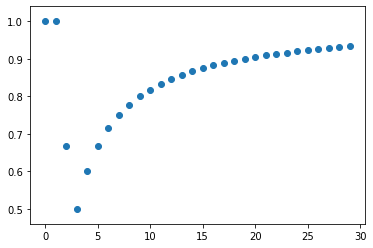

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5490196078431373
(133, 55)
2022-02-02 15:15:00
2022-02-09 15:45:00
(29, 15)
2022-02-08 15:15:00
2022-02-09 15:45:00
% Model match:  0.896551724137931


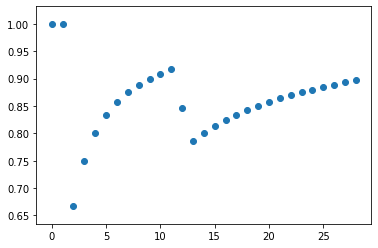

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5588235294117647
(132, 55)
2022-02-02 15:30:00
2022-02-09 15:45:00
(28, 15)
2022-02-08 15:30:00
2022-02-09 15:45:00
% Model match:  1.0


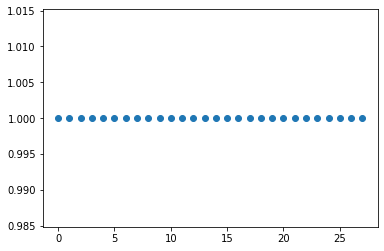

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5686274509803921
(131, 55)
2022-02-02 15:45:00
2022-02-09 15:45:00
(27, 15)
2022-02-08 15:45:00
2022-02-09 15:45:00
% Model match:  0.9629629629629629


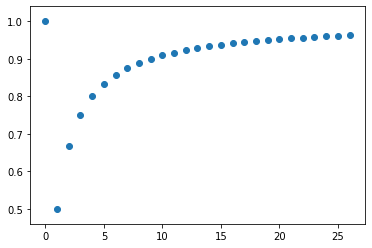

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5980392156862745
(155, 55)
2022-02-03 09:45:00
2022-02-10 15:45:00
(51, 15)
2022-02-09 09:45:00
2022-02-10 15:45:00
% Model match:  0.9607843137254902


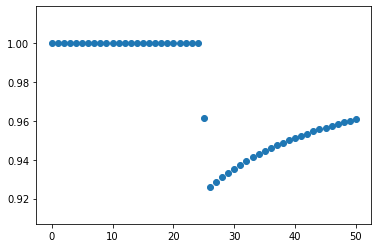

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5784313725490197
(154, 55)
2022-02-03 10:00:00
2022-02-10 15:45:00
(50, 15)
2022-02-09 10:00:00
2022-02-10 15:45:00
% Model match:  0.96


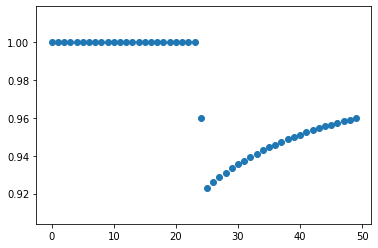

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5980392156862745
(153, 55)
2022-02-03 10:15:00
2022-02-10 15:45:00
(49, 15)
2022-02-09 10:15:00
2022-02-10 15:45:00
% Model match:  0.9387755102040817


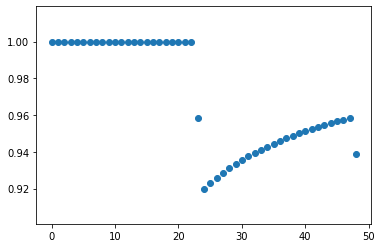

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5784313725490197
(152, 55)
2022-02-03 10:30:00
2022-02-10 15:45:00
(48, 15)
2022-02-09 10:30:00
2022-02-10 15:45:00
% Model match:  0.9583333333333334


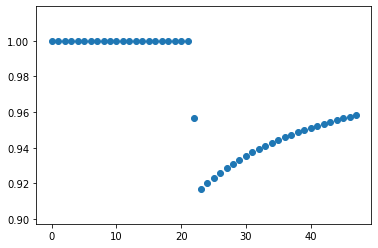

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5882352941176471
(151, 55)
2022-02-03 10:45:00
2022-02-10 15:45:00
(47, 15)
2022-02-09 10:45:00
2022-02-10 15:45:00
% Model match:  0.8936170212765957


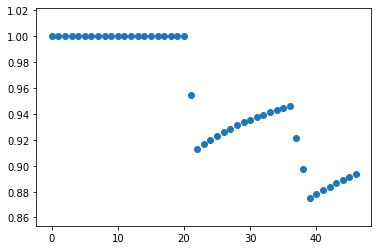

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5980392156862745
(150, 55)
2022-02-03 11:00:00
2022-02-10 15:45:00
(46, 15)
2022-02-09 11:00:00
2022-02-10 15:45:00
% Model match:  0.9130434782608695


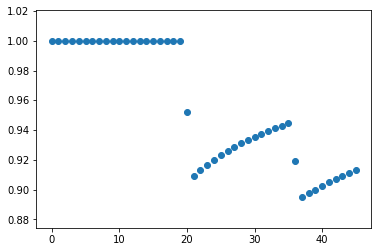

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(149, 55)
2022-02-03 11:15:00
2022-02-10 15:45:00
(45, 15)
2022-02-09 11:15:00
2022-02-10 15:45:00
% Model match:  0.9111111111111111


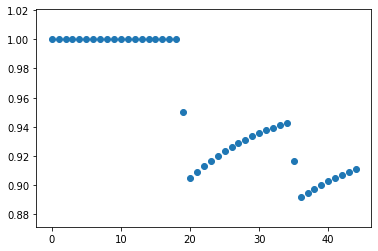

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5784313725490197
(148, 55)
2022-02-03 11:30:00
2022-02-10 15:45:00
(44, 15)
2022-02-09 11:30:00
2022-02-10 15:45:00
% Model match:  0.9090909090909091


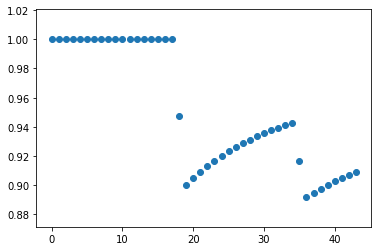

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(147, 55)
2022-02-03 11:45:00
2022-02-10 15:45:00
(43, 15)
2022-02-09 11:45:00
2022-02-10 15:45:00
% Model match:  0.8837209302325582


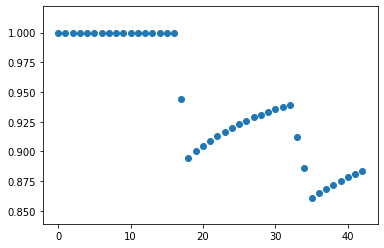

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5980392156862745
(146, 55)
2022-02-03 12:00:00
2022-02-10 15:45:00
(42, 15)
2022-02-09 12:00:00
2022-02-10 15:45:00
% Model match:  0.8809523809523809


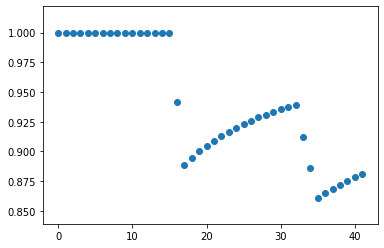

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(145, 55)
2022-02-03 12:15:00
2022-02-10 15:45:00
(41, 15)
2022-02-09 12:15:00
2022-02-10 15:45:00
% Model match:  0.8536585365853658


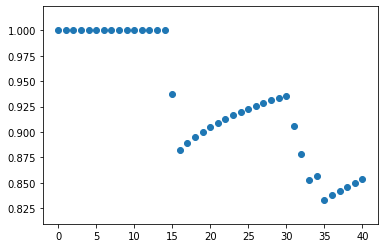

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5882352941176471
(144, 55)
2022-02-03 12:30:00
2022-02-10 15:45:00
(40, 15)
2022-02-09 12:30:00
2022-02-10 15:45:00
% Model match:  0.825


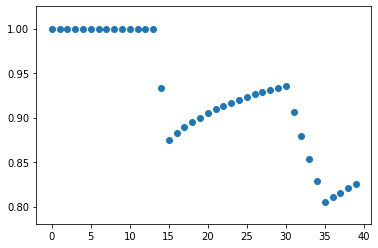

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(143, 55)
2022-02-03 12:45:00
2022-02-10 15:45:00
(39, 15)
2022-02-09 12:45:00
2022-02-10 15:45:00
% Model match:  0.8717948717948718


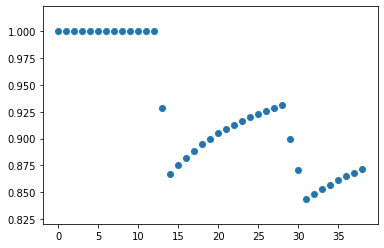

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(142, 55)
2022-02-03 13:00:00
2022-02-10 15:45:00
(38, 15)
2022-02-09 13:00:00
2022-02-10 15:45:00
% Model match:  0.7894736842105263


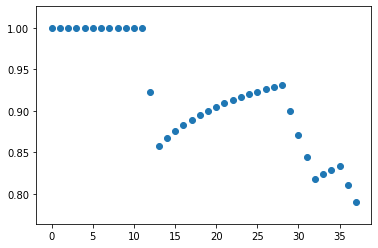

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6764705882352942
(141, 55)
2022-02-03 13:15:00
2022-02-10 15:45:00
(37, 15)
2022-02-09 13:15:00
2022-02-10 15:45:00
% Model match:  0.7837837837837838


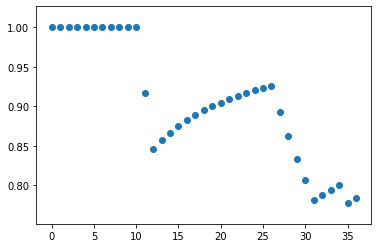

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6078431372549019
(140, 55)
2022-02-03 13:30:00
2022-02-10 15:45:00
(36, 15)
2022-02-09 13:30:00
2022-02-10 15:45:00
% Model match:  0.6388888888888888


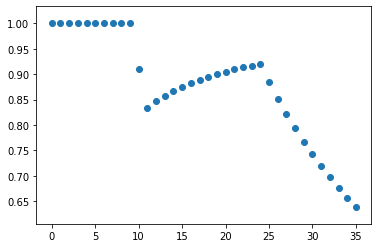

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6764705882352942
(139, 55)
2022-02-03 13:45:00
2022-02-10 15:45:00
(35, 15)
2022-02-09 13:45:00
2022-02-10 15:45:00
% Model match:  0.6571428571428571


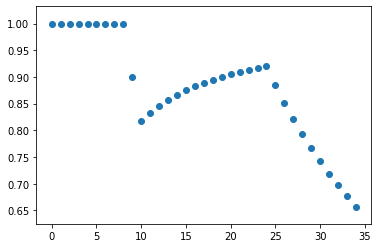

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.5980392156862745
(138, 55)
2022-02-03 14:00:00
2022-02-10 15:45:00
(34, 15)
2022-02-09 14:00:00
2022-02-10 15:45:00
% Model match:  0.6470588235294118


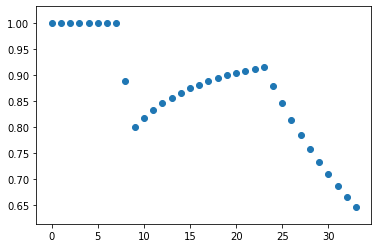

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7156862745098039
(137, 55)
2022-02-03 14:15:00
2022-02-10 15:45:00
(33, 15)
2022-02-09 14:15:00
2022-02-10 15:45:00
% Model match:  0.6363636363636364


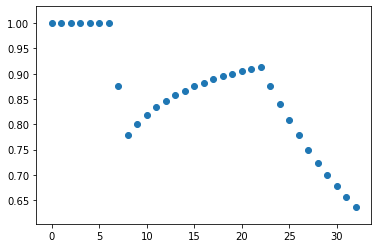

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(136, 55)
2022-02-03 14:30:00
2022-02-10 15:45:00
(32, 15)
2022-02-09 14:30:00
2022-02-10 15:45:00
% Model match:  0.625


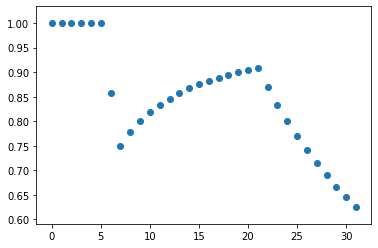

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.696078431372549
(135, 55)
2022-02-03 14:45:00
2022-02-10 15:45:00
(31, 15)
2022-02-09 14:45:00
2022-02-10 15:45:00
% Model match:  0.6129032258064516


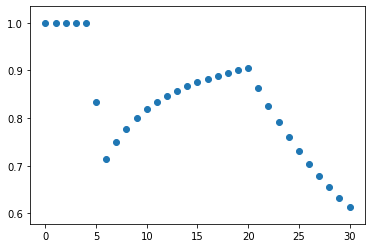

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(134, 55)
2022-02-03 15:00:00
2022-02-10 15:45:00
(30, 15)
2022-02-09 15:00:00
2022-02-10 15:45:00
% Model match:  0.6


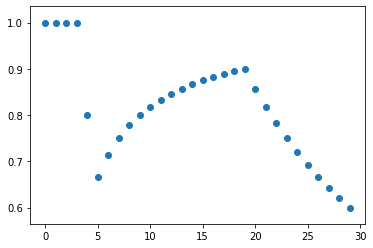

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7254901960784313
(133, 55)
2022-02-03 15:15:00
2022-02-10 15:45:00
(29, 15)
2022-02-09 15:15:00
2022-02-10 15:45:00
% Model match:  0.5862068965517241


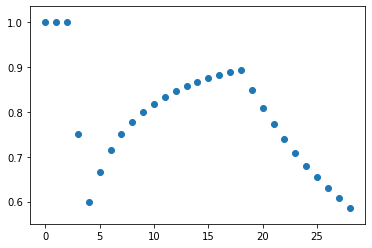

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(132, 55)
2022-02-03 15:30:00
2022-02-10 15:45:00
(28, 15)
2022-02-09 15:30:00
2022-02-10 15:45:00
% Model match:  0.6071428571428571


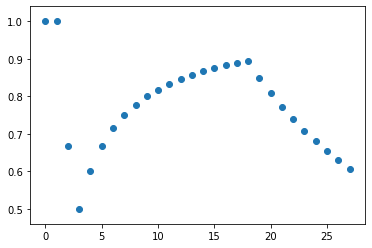

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7156862745098039
(131, 55)
2022-02-03 15:45:00
2022-02-10 15:45:00
(27, 15)
2022-02-09 15:45:00
2022-02-10 15:45:00
% Model match:  0.5555555555555556


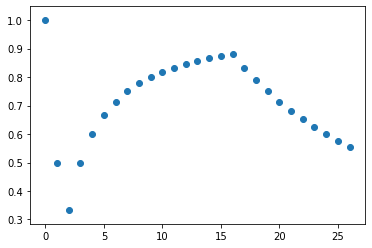

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7352941176470589
(155, 55)
2022-02-04 09:45:00
2022-02-11 15:45:00
(51, 15)
2022-02-10 09:45:00
2022-02-11 15:45:00
% Model match:  0.11764705882352941


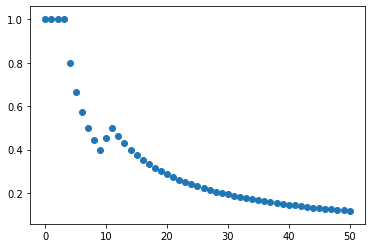

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6372549019607843
(154, 55)
2022-02-04 10:00:00
2022-02-11 15:45:00
(50, 15)
2022-02-10 10:00:00
2022-02-11 15:45:00
% Model match:  0.02


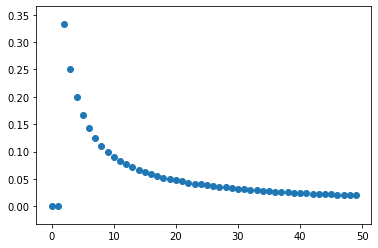

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7352941176470589
(153, 55)
2022-02-04 10:15:00
2022-02-11 15:45:00
(49, 15)
2022-02-10 10:15:00
2022-02-11 15:45:00
% Model match:  0.12244897959183673


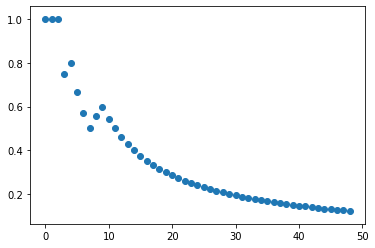

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(152, 55)
2022-02-04 10:30:00
2022-02-11 15:45:00
(48, 15)
2022-02-10 10:30:00
2022-02-11 15:45:00
% Model match:  0.1875


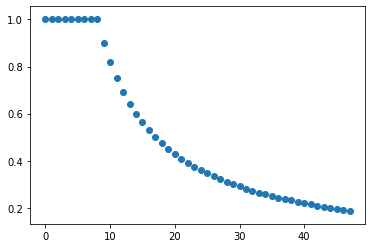

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6862745098039216
(151, 55)
2022-02-04 10:45:00
2022-02-11 15:45:00
(47, 15)
2022-02-10 10:45:00
2022-02-11 15:45:00
% Model match:  0.1702127659574468


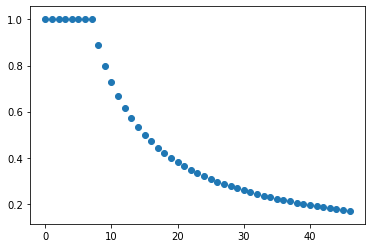

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(150, 55)
2022-02-04 11:00:00
2022-02-11 15:45:00
(46, 15)
2022-02-10 11:00:00
2022-02-11 15:45:00
% Model match:  0.17391304347826086


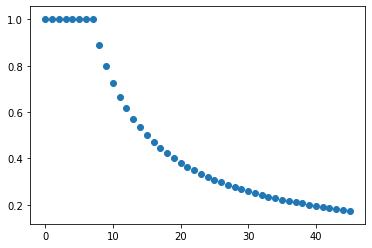

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7254901960784313
(149, 55)
2022-02-04 11:15:00
2022-02-11 15:45:00
(45, 15)
2022-02-10 11:15:00
2022-02-11 15:45:00
% Model match:  0.15555555555555556


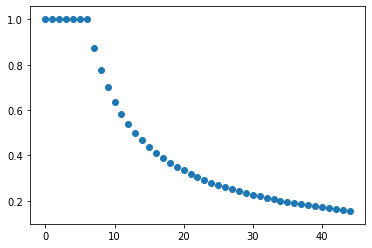

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6568627450980392
(148, 55)
2022-02-04 11:30:00
2022-02-11 15:45:00
(44, 15)
2022-02-10 11:30:00
2022-02-11 15:45:00
% Model match:  0.13636363636363635


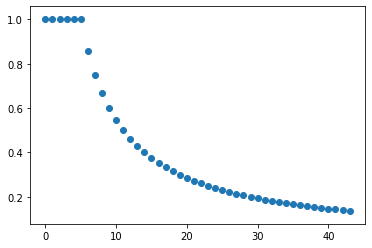

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7156862745098039
(147, 55)
2022-02-04 11:45:00
2022-02-11 15:45:00
(43, 15)
2022-02-10 11:45:00
2022-02-11 15:45:00
% Model match:  0.13953488372093023


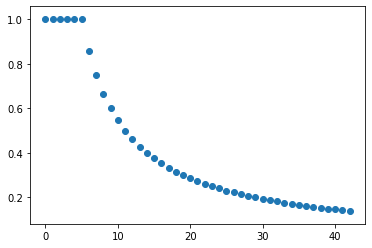

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(146, 55)
2022-02-04 12:00:00
2022-02-11 15:45:00
(42, 15)
2022-02-10 12:00:00
2022-02-11 15:45:00
% Model match:  0.14285714285714285


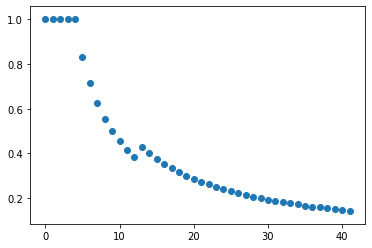

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7254901960784313
(145, 55)
2022-02-04 12:15:00
2022-02-11 15:45:00
(41, 15)
2022-02-10 12:15:00
2022-02-11 15:45:00
% Model match:  0.0975609756097561


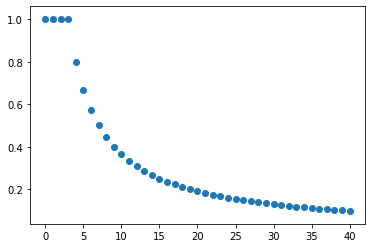

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(144, 55)
2022-02-04 12:30:00
2022-02-11 15:45:00
(40, 15)
2022-02-10 12:30:00
2022-02-11 15:45:00
% Model match:  0.1


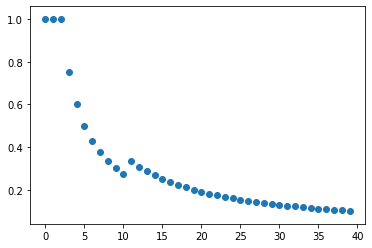

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7254901960784313
(143, 55)
2022-02-04 12:45:00
2022-02-11 15:45:00
(39, 15)
2022-02-10 12:45:00
2022-02-11 15:45:00
% Model match:  0.07692307692307693


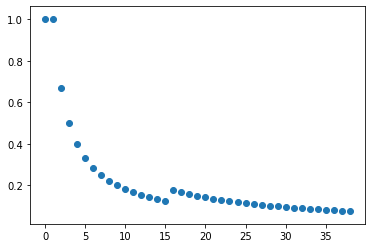

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6274509803921569
(142, 55)
2022-02-04 13:00:00
2022-02-11 15:45:00
(38, 15)
2022-02-10 13:00:00
2022-02-11 15:45:00
% Model match:  0.18421052631578946


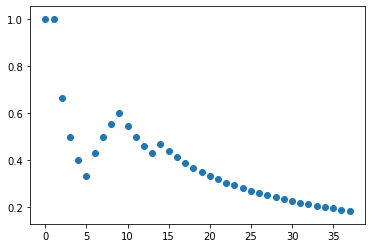

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7254901960784313
(141, 55)
2022-02-04 13:15:00
2022-02-11 15:45:00
(37, 15)
2022-02-10 13:15:00
2022-02-11 15:45:00
% Model match:  0.21621621621621623


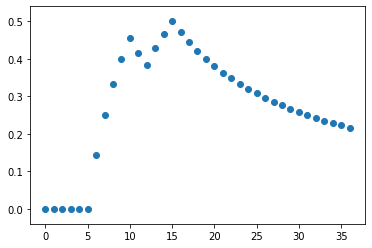

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(140, 55)
2022-02-04 13:30:00
2022-02-11 15:45:00
(36, 15)
2022-02-10 13:30:00
2022-02-11 15:45:00
% Model match:  0.2777777777777778


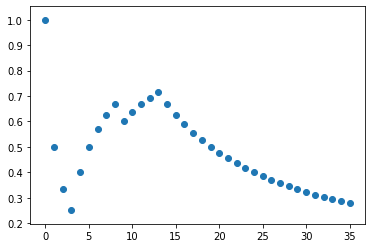

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7156862745098039
(139, 55)
2022-02-04 13:45:00
2022-02-11 15:45:00
(35, 15)
2022-02-10 13:45:00
2022-02-11 15:45:00
% Model match:  0.2571428571428571


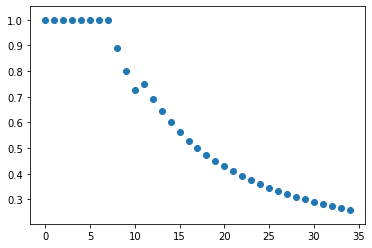

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6666666666666666
(138, 55)
2022-02-04 14:00:00
2022-02-11 15:45:00
(34, 15)
2022-02-10 14:00:00
2022-02-11 15:45:00
% Model match:  0.29411764705882354


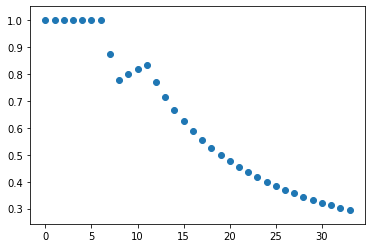

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7450980392156863
(137, 55)
2022-02-04 14:15:00
2022-02-11 15:45:00
(33, 15)
2022-02-10 14:15:00
2022-02-11 15:45:00
% Model match:  0.2727272727272727


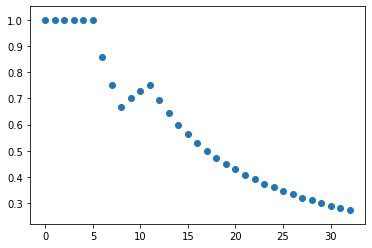

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6764705882352942
(136, 55)
2022-02-04 14:30:00
2022-02-11 15:45:00
(32, 15)
2022-02-10 14:30:00
2022-02-11 15:45:00
% Model match:  0.28125


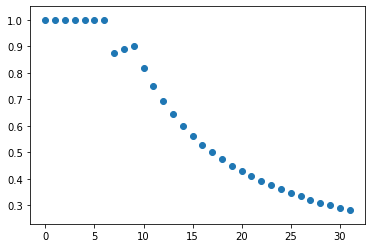

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7156862745098039
(135, 55)
2022-02-04 14:45:00
2022-02-11 15:45:00
(31, 15)
2022-02-10 14:45:00
2022-02-11 15:45:00
% Model match:  0.3225806451612903


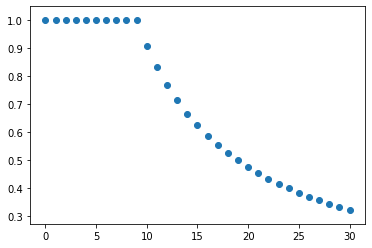

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6764705882352942
(134, 55)
2022-02-04 15:00:00
2022-02-11 15:45:00
(30, 15)
2022-02-10 15:00:00
2022-02-11 15:45:00
% Model match:  0.16666666666666666


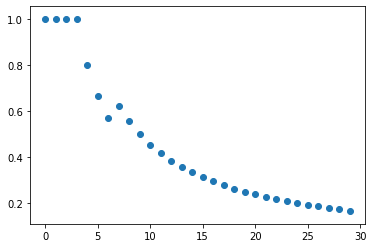

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7156862745098039
(133, 55)
2022-02-04 15:15:00
2022-02-11 15:45:00
(29, 15)
2022-02-10 15:15:00
2022-02-11 15:45:00
% Model match:  0.27586206896551724


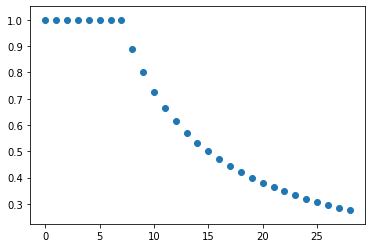

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6470588235294118
(132, 55)
2022-02-04 15:30:00
2022-02-11 15:45:00
(28, 15)
2022-02-10 15:30:00
2022-02-11 15:45:00
% Model match:  0.14285714285714285


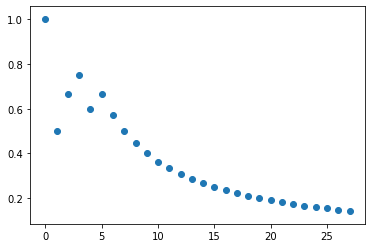

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.696078431372549
(131, 55)
2022-02-04 15:45:00
2022-02-11 15:45:00
(27, 15)
2022-02-10 15:45:00
2022-02-11 15:45:00
% Model match:  0.14814814814814814


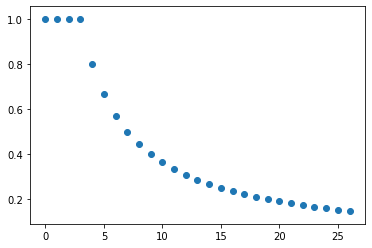

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.696078431372549
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(25, 15)
2022-02-11 09:45:00
2022-02-11 15:45:00
% Model match:  0.16


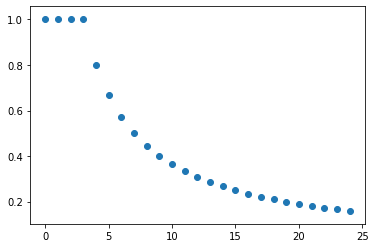

Number of splits for CV:  52
Fitting 52 folds for each of 1 candidates, totalling 52 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6923076923076923
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(24, 15)
2022-02-11 10:00:00
2022-02-11 15:45:00
% Model match:  0.125


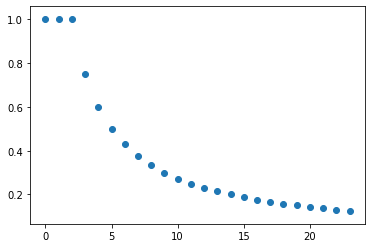

Number of splits for CV:  53
Fitting 53 folds for each of 1 candidates, totalling 53 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.8301886792452831
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(23, 15)
2022-02-11 10:15:00
2022-02-11 15:45:00
% Model match:  0.34782608695652173


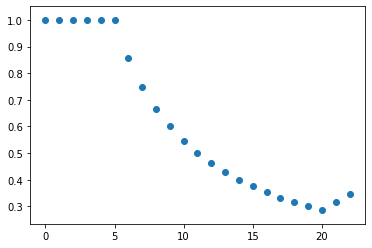

Number of splits for CV:  53
Fitting 53 folds for each of 1 candidates, totalling 53 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6981132075471698
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(22, 15)
2022-02-11 10:30:00
2022-02-11 15:45:00
% Model match:  0.2727272727272727


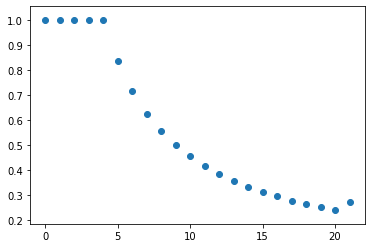

Number of splits for CV:  53
Fitting 53 folds for each of 1 candidates, totalling 53 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7075471698113207
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(21, 15)
2022-02-11 10:45:00
2022-02-11 15:45:00
% Model match:  0.38095238095238093


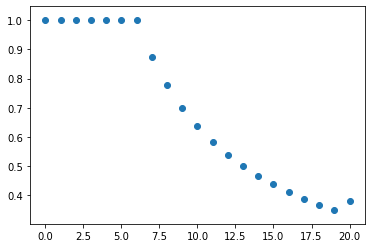

Number of splits for CV:  54
Fitting 54 folds for each of 1 candidates, totalling 54 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7037037037037037
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(20, 15)
2022-02-11 11:00:00
2022-02-11 15:45:00
% Model match:  0.25


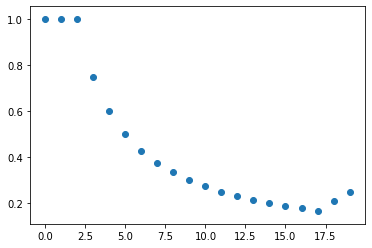

Number of splits for CV:  55
Fitting 55 folds for each of 1 candidates, totalling 55 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.8363636363636363
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(19, 15)
2022-02-11 11:15:00
2022-02-11 15:45:00
% Model match:  0.21052631578947367


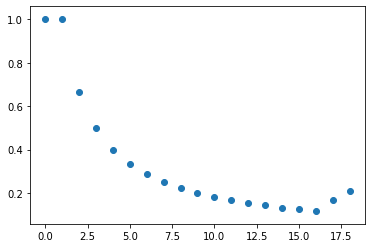

Number of splits for CV:  55
Fitting 55 folds for each of 1 candidates, totalling 55 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7090909090909091
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(18, 15)
2022-02-11 11:30:00
2022-02-11 15:45:00
% Model match:  0.5555555555555556


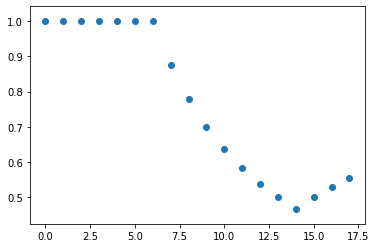

Number of splits for CV:  55
Fitting 55 folds for each of 1 candidates, totalling 55 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7181818181818181
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(17, 15)
2022-02-11 11:45:00
2022-02-11 15:45:00
% Model match:  0.5882352941176471


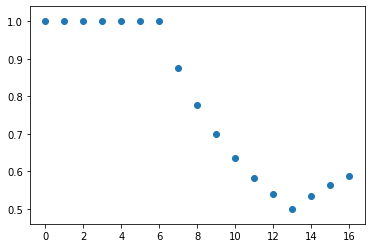

Number of splits for CV:  56
Fitting 56 folds for each of 1 candidates, totalling 56 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7142857142857143
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(16, 15)
2022-02-11 12:00:00
2022-02-11 15:45:00
% Model match:  0.5625


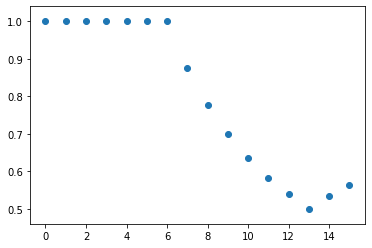

Number of splits for CV:  57
Fitting 57 folds for each of 1 candidates, totalling 57 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.8421052631578947
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(15, 15)
2022-02-11 12:15:00
2022-02-11 15:45:00
% Model match:  0.4666666666666667


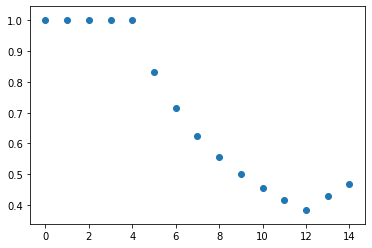

Number of splits for CV:  57
Fitting 57 folds for each of 1 candidates, totalling 57 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7192982456140351
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(14, 15)
2022-02-11 12:30:00
2022-02-11 15:45:00
% Model match:  0.5


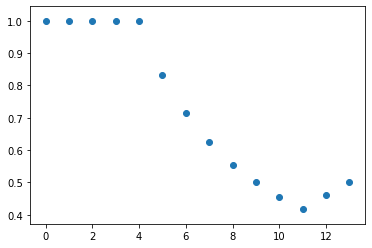

Number of splits for CV:  57
Fitting 57 folds for each of 1 candidates, totalling 57 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7280701754385965
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(13, 15)
2022-02-11 12:45:00
2022-02-11 15:45:00
% Model match:  0.5384615384615384


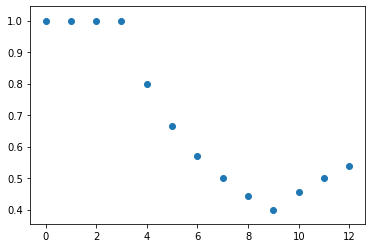

Number of splits for CV:  58
Fitting 58 folds for each of 1 candidates, totalling 58 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7241379310344828
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(12, 15)
2022-02-11 13:00:00
2022-02-11 15:45:00
% Model match:  0.5833333333333334


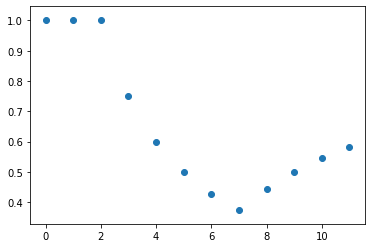

Number of splits for CV:  59
Fitting 59 folds for each of 1 candidates, totalling 59 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.847457627118644
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(11, 15)
2022-02-11 13:15:00
2022-02-11 15:45:00
% Model match:  1.0


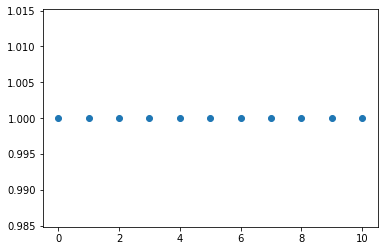

Number of splits for CV:  59
Fitting 59 folds for each of 1 candidates, totalling 59 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7288135593220338
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(10, 15)
2022-02-11 13:30:00
2022-02-11 15:45:00
% Model match:  1.0


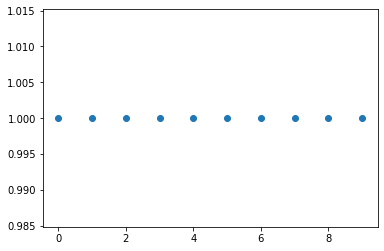

Number of splits for CV:  59
Fitting 59 folds for each of 1 candidates, totalling 59 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7372881355932204
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(9, 15)
2022-02-11 13:45:00
2022-02-11 15:45:00
% Model match:  1.0


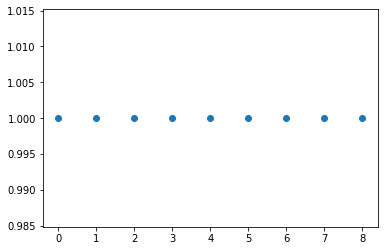

Number of splits for CV:  60
Fitting 60 folds for each of 1 candidates, totalling 60 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.725
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(8, 15)
2022-02-11 14:00:00
2022-02-11 15:45:00
% Model match:  1.0


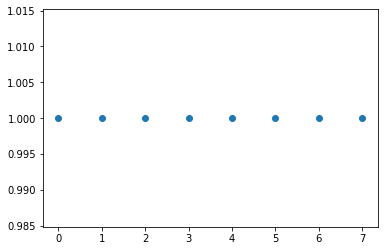

Number of splits for CV:  61
Fitting 61 folds for each of 1 candidates, totalling 61 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.819672131147541
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(7, 15)
2022-02-11 14:15:00
2022-02-11 15:45:00
% Model match:  1.0


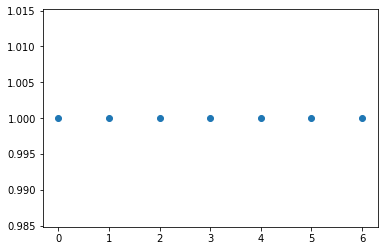

Number of splits for CV:  61
Fitting 61 folds for each of 1 candidates, totalling 61 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7213114754098361
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(6, 15)
2022-02-11 14:30:00
2022-02-11 15:45:00
% Model match:  1.0


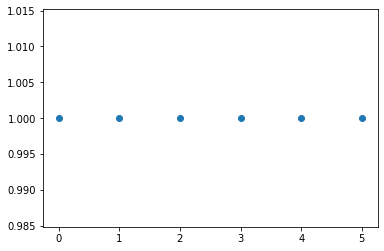

Number of splits for CV:  61
Fitting 61 folds for each of 1 candidates, totalling 61 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7213114754098361
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(5, 15)
2022-02-11 14:45:00
2022-02-11 15:45:00
% Model match:  1.0


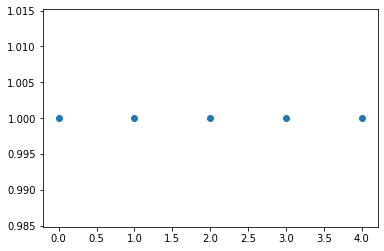

Number of splits for CV:  62
Fitting 62 folds for each of 1 candidates, totalling 62 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7258064516129032
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(4, 15)
2022-02-11 15:00:00
2022-02-11 15:45:00
% Model match:  1.0


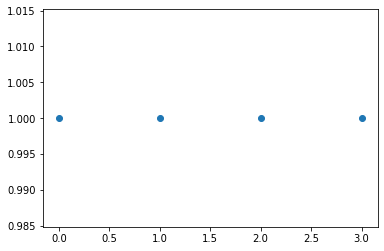

Number of splits for CV:  63
Fitting 63 folds for each of 1 candidates, totalling 63 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.8095238095238095
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(3, 15)
2022-02-11 15:15:00
2022-02-11 15:45:00
% Model match:  1.0


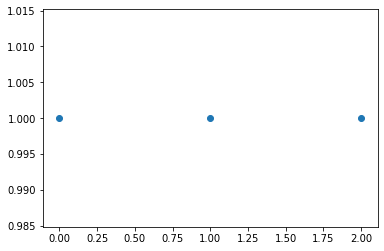

Number of splits for CV:  63
Fitting 63 folds for each of 1 candidates, totalling 63 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7301587301587301
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(2, 15)
2022-02-11 15:30:00
2022-02-11 15:45:00
% Model match:  1.0


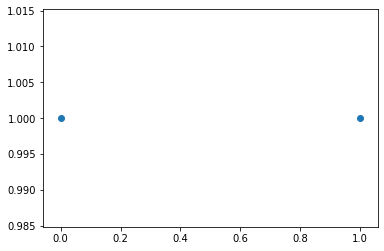

Number of splits for CV:  63
Fitting 63 folds for each of 1 candidates, totalling 63 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7301587301587301
(130, 55)
2022-02-07 09:30:00
2022-02-11 15:45:00
(1, 15)
2022-02-11 15:45:00
2022-02-11 15:45:00
% Model match:  1.0


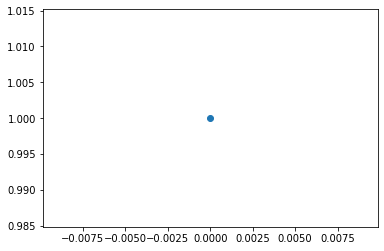

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7745098039215687
(155, 55)
2022-02-08 09:45:00
2022-02-15 15:45:00
(51, 15)
2022-02-14 09:45:00
2022-02-15 15:45:00
% Model match:  0.4117647058823529


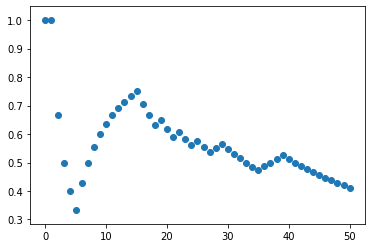

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.803921568627451
(154, 55)
2022-02-08 10:00:00
2022-02-15 15:45:00
(50, 15)
2022-02-14 10:00:00
2022-02-15 15:45:00
% Model match:  0.38


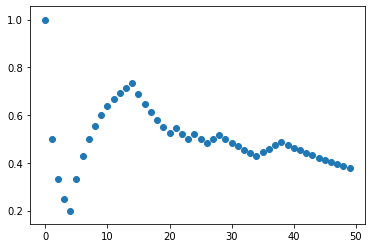

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7843137254901961
(153, 55)
2022-02-08 10:15:00
2022-02-15 15:45:00
(49, 15)
2022-02-14 10:15:00
2022-02-15 15:45:00
% Model match:  0.3877551020408163


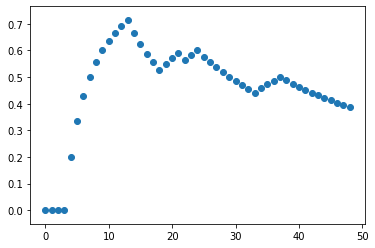

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7647058823529411
(152, 55)
2022-02-08 10:30:00
2022-02-15 15:45:00
(48, 15)
2022-02-14 10:30:00
2022-02-15 15:45:00
% Model match:  0.5416666666666666


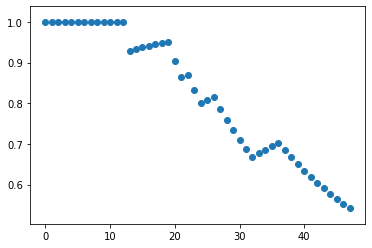

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7745098039215687
(151, 55)
2022-02-08 10:45:00
2022-02-15 15:45:00
(47, 15)
2022-02-14 10:45:00
2022-02-15 15:45:00
% Model match:  0.46808510638297873


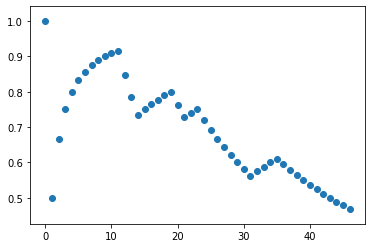

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7843137254901961
(150, 55)
2022-02-08 11:00:00
2022-02-15 15:45:00
(46, 15)
2022-02-14 11:00:00
2022-02-15 15:45:00
% Model match:  0.5


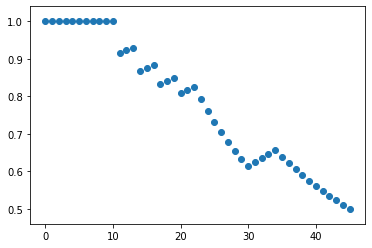

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7941176470588235
(149, 55)
2022-02-08 11:15:00
2022-02-15 15:45:00
(45, 15)
2022-02-14 11:15:00
2022-02-15 15:45:00
% Model match:  0.4666666666666667


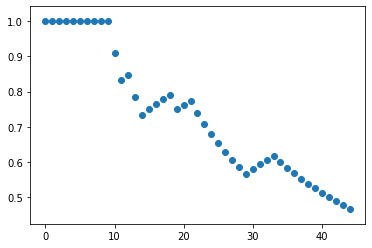

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7647058823529411
(148, 55)
2022-02-08 11:30:00
2022-02-15 15:45:00
(44, 15)
2022-02-14 11:30:00
2022-02-15 15:45:00
% Model match:  0.3409090909090909


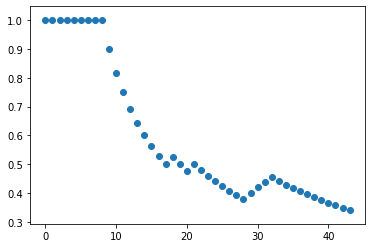

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7647058823529411
(147, 55)
2022-02-08 11:45:00
2022-02-15 15:45:00
(43, 15)
2022-02-14 11:45:00
2022-02-15 15:45:00
% Model match:  0.4186046511627907


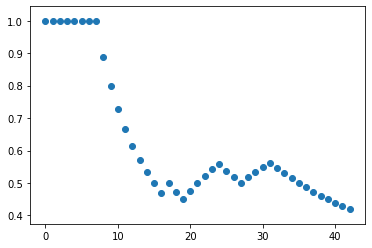

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7549019607843137
(146, 55)
2022-02-08 12:00:00
2022-02-15 15:45:00
(42, 15)
2022-02-14 12:00:00
2022-02-15 15:45:00
% Model match:  0.42857142857142855


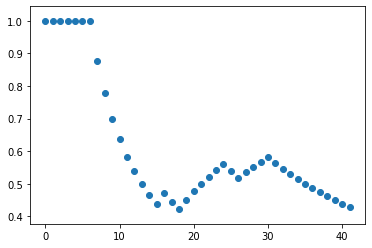

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7843137254901961
(145, 55)
2022-02-08 12:15:00
2022-02-15 15:45:00
(41, 15)
2022-02-14 12:15:00
2022-02-15 15:45:00
% Model match:  0.3170731707317073


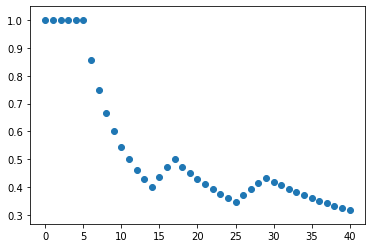

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7450980392156863
(144, 55)
2022-02-08 12:30:00
2022-02-15 15:45:00
(40, 15)
2022-02-14 12:30:00
2022-02-15 15:45:00
% Model match:  0.25


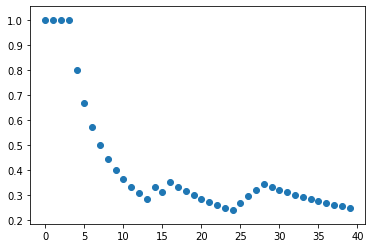

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7941176470588235
(143, 55)
2022-02-08 12:45:00
2022-02-15 15:45:00
(39, 15)
2022-02-14 12:45:00
2022-02-15 15:45:00
% Model match:  0.41025641025641024


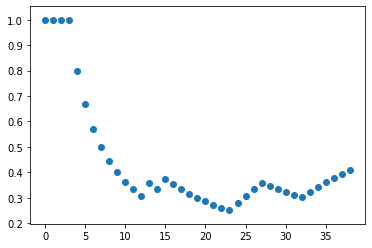

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7549019607843137
(142, 55)
2022-02-08 13:00:00
2022-02-15 15:45:00
(38, 15)
2022-02-14 13:00:00
2022-02-15 15:45:00
% Model match:  0.3684210526315789


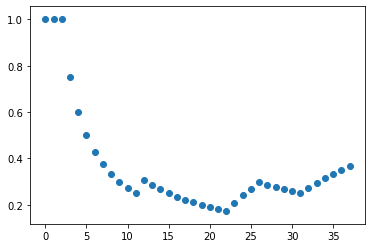

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.8235294117647058
(141, 55)
2022-02-08 13:15:00
2022-02-15 15:45:00
(37, 15)
2022-02-14 13:15:00
2022-02-15 15:45:00
% Model match:  0.5675675675675675


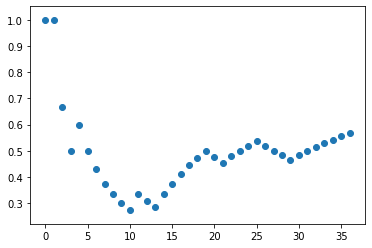

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7745098039215687
(140, 55)
2022-02-08 13:30:00
2022-02-15 15:45:00
(36, 15)
2022-02-14 13:30:00
2022-02-15 15:45:00
% Model match:  0.5


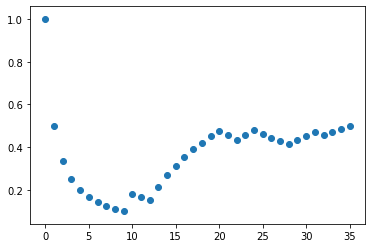

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7843137254901961
(139, 55)
2022-02-08 13:45:00
2022-02-15 15:45:00
(35, 15)
2022-02-14 13:45:00
2022-02-15 15:45:00
% Model match:  0.42857142857142855


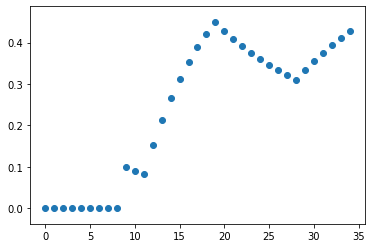

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7647058823529411
(138, 55)
2022-02-08 14:00:00
2022-02-15 15:45:00
(34, 15)
2022-02-14 14:00:00
2022-02-15 15:45:00
% Model match:  0.5588235294117647


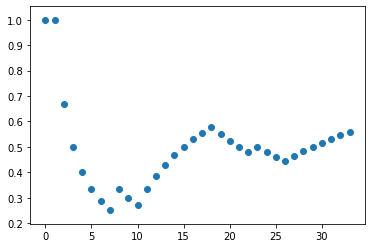

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7941176470588235
(137, 55)
2022-02-08 14:15:00
2022-02-15 15:45:00
(33, 15)
2022-02-14 14:15:00
2022-02-15 15:45:00
% Model match:  0.6363636363636364


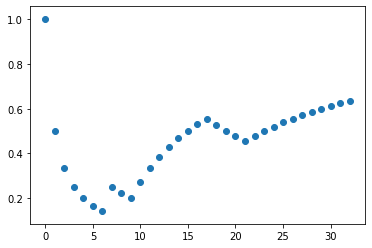

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7450980392156863
(136, 55)
2022-02-08 14:30:00
2022-02-15 15:45:00
(32, 15)
2022-02-14 14:30:00
2022-02-15 15:45:00
% Model match:  0.71875


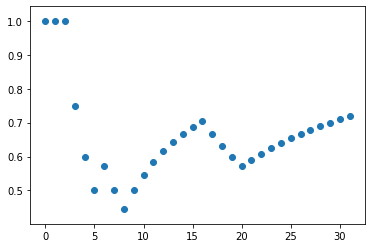

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.8137254901960784
(135, 55)
2022-02-08 14:45:00
2022-02-15 15:45:00
(31, 15)
2022-02-14 14:45:00
2022-02-15 15:45:00
% Model match:  0.6774193548387096


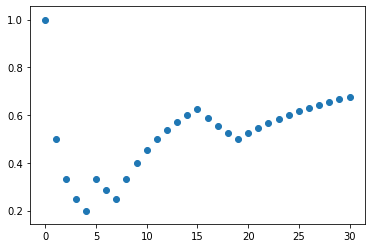

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7745098039215687
(134, 55)
2022-02-08 15:00:00
2022-02-15 15:45:00
(30, 15)
2022-02-14 15:00:00
2022-02-15 15:45:00
% Model match:  0.6


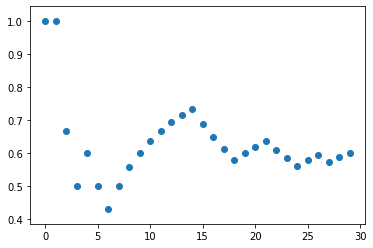

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7647058823529411
(133, 55)
2022-02-08 15:15:00
2022-02-15 15:45:00
(29, 15)
2022-02-14 15:15:00
2022-02-15 15:45:00
% Model match:  0.5862068965517241


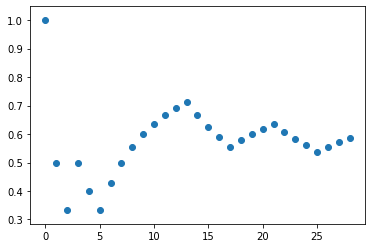

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7941176470588235
(132, 55)
2022-02-08 15:30:00
2022-02-15 15:45:00
(28, 15)
2022-02-14 15:30:00
2022-02-15 15:45:00
% Model match:  0.7142857142857143


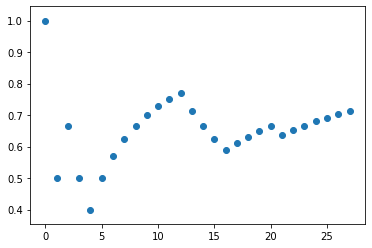

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7745098039215687
(131, 55)
2022-02-08 15:45:00
2022-02-15 15:45:00
(27, 15)
2022-02-14 15:45:00
2022-02-15 15:45:00
% Model match:  0.6296296296296297


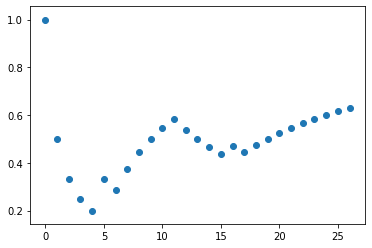

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7549019607843137
(155, 55)
2022-02-09 09:45:00
2022-02-16 15:45:00
(51, 15)
2022-02-15 09:45:00
2022-02-16 15:45:00
% Model match:  0.5098039215686274


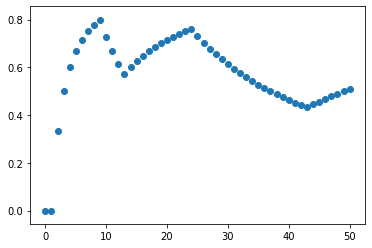

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7352941176470589
(154, 55)
2022-02-09 10:00:00
2022-02-16 15:45:00
(50, 15)
2022-02-15 10:00:00
2022-02-16 15:45:00
% Model match:  0.54


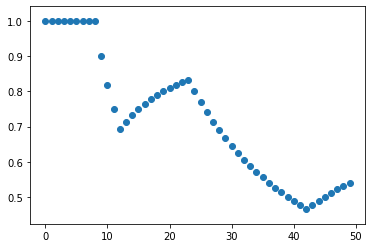

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7352941176470589
(153, 55)
2022-02-09 10:15:00
2022-02-16 15:45:00
(49, 15)
2022-02-15 10:15:00
2022-02-16 15:45:00
% Model match:  0.46938775510204084


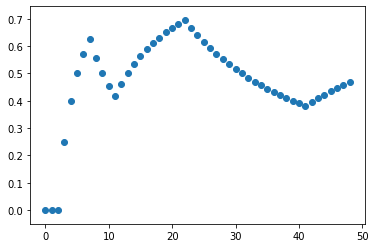

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7254901960784313
(152, 55)
2022-02-09 10:30:00
2022-02-16 15:45:00
(48, 15)
2022-02-15 10:30:00
2022-02-16 15:45:00
% Model match:  0.5208333333333334


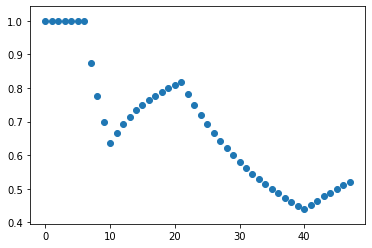

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7058823529411765
(151, 55)
2022-02-09 10:45:00
2022-02-16 15:45:00
(47, 15)
2022-02-15 10:45:00
2022-02-16 15:45:00
% Model match:  0.5106382978723404


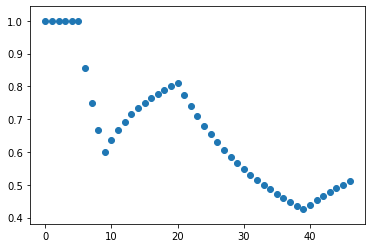

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7450980392156863
(150, 55)
2022-02-09 11:00:00
2022-02-16 15:45:00
(46, 15)
2022-02-15 11:00:00
2022-02-16 15:45:00
% Model match:  0.5


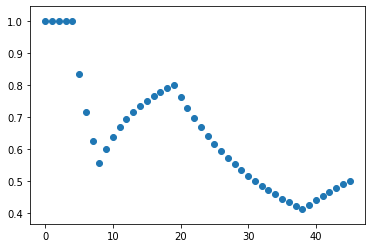

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7156862745098039
(149, 55)
2022-02-09 11:15:00
2022-02-16 15:45:00
(45, 15)
2022-02-15 11:15:00
2022-02-16 15:45:00
% Model match:  0.4888888888888889


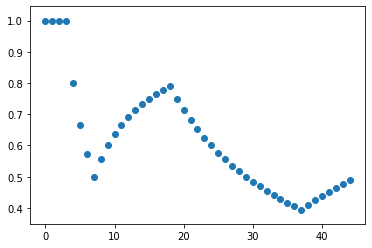

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7549019607843137
(148, 55)
2022-02-09 11:30:00
2022-02-16 15:45:00
(44, 15)
2022-02-15 11:30:00
2022-02-16 15:45:00
% Model match:  0.4772727272727273


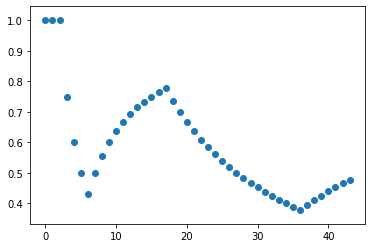

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7156862745098039
(147, 55)
2022-02-09 11:45:00
2022-02-16 15:45:00
(43, 15)
2022-02-15 11:45:00
2022-02-16 15:45:00
% Model match:  0.46511627906976744


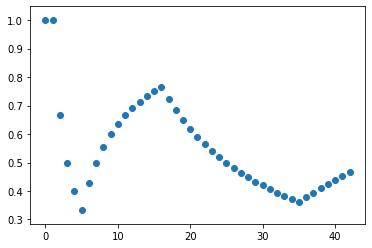

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7647058823529411
(146, 55)
2022-02-09 12:00:00
2022-02-16 15:45:00
(42, 15)
2022-02-15 12:00:00
2022-02-16 15:45:00
% Model match:  0.4523809523809524


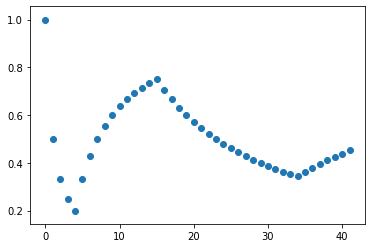

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7156862745098039
(145, 55)
2022-02-09 12:15:00
2022-02-16 15:45:00
(41, 15)
2022-02-15 12:15:00
2022-02-16 15:45:00
% Model match:  0.43902439024390244


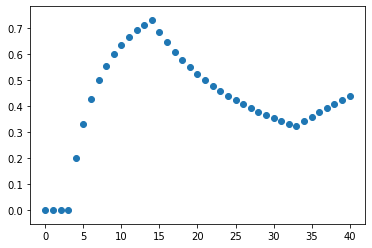

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7352941176470589
(144, 55)
2022-02-09 12:30:00
2022-02-16 15:45:00
(40, 15)
2022-02-15 12:30:00
2022-02-16 15:45:00
% Model match:  0.45


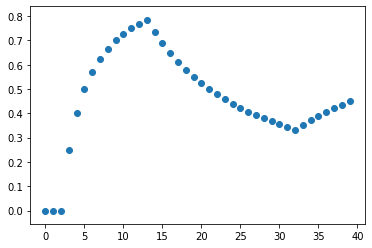

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.696078431372549
(143, 55)
2022-02-09 12:45:00
2022-02-16 15:45:00
(39, 15)
2022-02-15 12:45:00
2022-02-16 15:45:00
% Model match:  0.5128205128205128


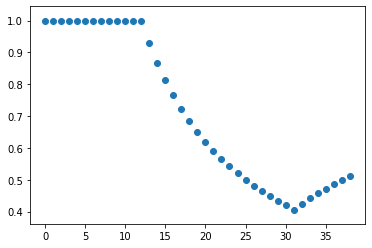

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7156862745098039
(142, 55)
2022-02-09 13:00:00
2022-02-16 15:45:00
(38, 15)
2022-02-15 13:00:00
2022-02-16 15:45:00
% Model match:  0.47368421052631576


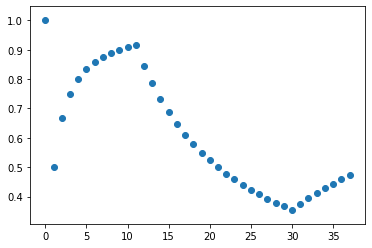

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6862745098039216
(141, 55)
2022-02-09 13:15:00
2022-02-16 15:45:00
(37, 15)
2022-02-15 13:15:00
2022-02-16 15:45:00
% Model match:  0.43243243243243246


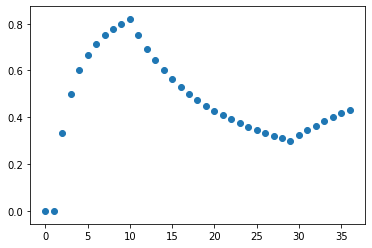

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7156862745098039
(140, 55)
2022-02-09 13:30:00
2022-02-16 15:45:00
(36, 15)
2022-02-15 13:30:00
2022-02-16 15:45:00
% Model match:  0.4722222222222222


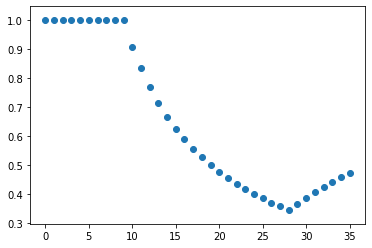

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6764705882352942
(139, 55)
2022-02-09 13:45:00
2022-02-16 15:45:00
(35, 15)
2022-02-15 13:45:00
2022-02-16 15:45:00
% Model match:  0.45714285714285713


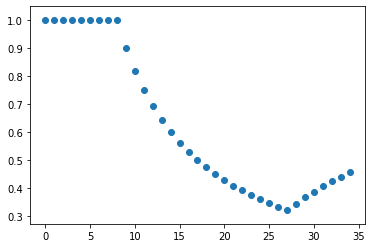

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.696078431372549
(138, 55)
2022-02-09 14:00:00
2022-02-16 15:45:00
(34, 15)
2022-02-15 14:00:00
2022-02-16 15:45:00
% Model match:  0.4411764705882353


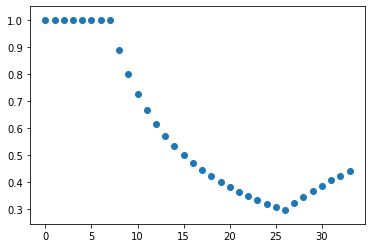

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6764705882352942
(137, 55)
2022-02-09 14:15:00
2022-02-16 15:45:00
(33, 15)
2022-02-15 14:15:00
2022-02-16 15:45:00
% Model match:  0.42424242424242425


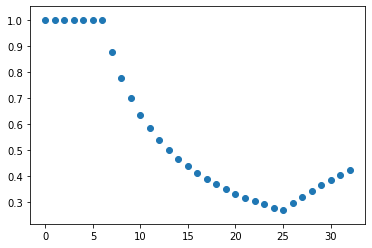

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7254901960784313
(136, 55)
2022-02-09 14:30:00
2022-02-16 15:45:00
(32, 15)
2022-02-15 14:30:00
2022-02-16 15:45:00
% Model match:  0.40625


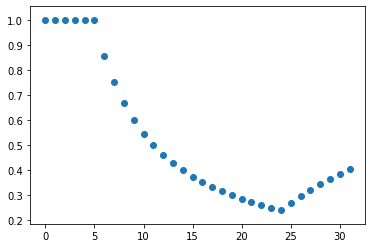

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6764705882352942
(135, 55)
2022-02-09 14:45:00
2022-02-16 15:45:00
(31, 15)
2022-02-15 14:45:00
2022-02-16 15:45:00
% Model match:  0.3870967741935484


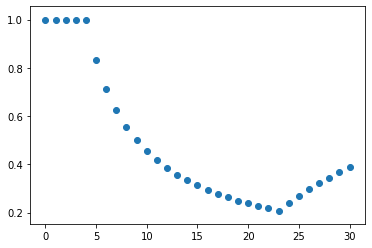

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.7058823529411765
(134, 55)
2022-02-09 15:00:00
2022-02-16 15:45:00
(30, 15)
2022-02-15 15:00:00
2022-02-16 15:45:00
% Model match:  0.36666666666666664


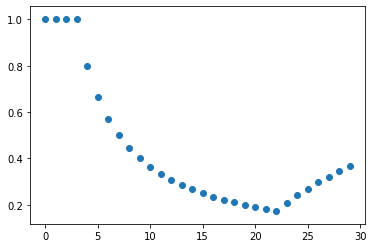

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.696078431372549
(133, 55)
2022-02-09 15:15:00
2022-02-16 15:45:00
(29, 15)
2022-02-15 15:15:00
2022-02-16 15:45:00
% Model match:  0.3448275862068966


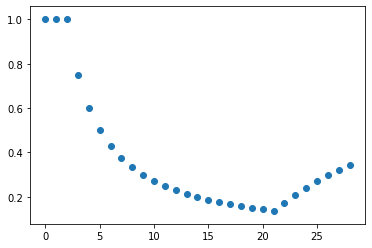

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.696078431372549
(132, 55)
2022-02-09 15:30:00
2022-02-16 15:45:00
(28, 15)
2022-02-15 15:30:00
2022-02-16 15:45:00
% Model match:  0.32142857142857145


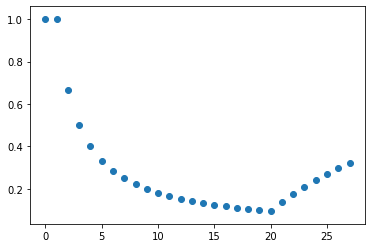

Number of splits for CV:  51
Fitting 51 folds for each of 1 candidates, totalling 51 fits
Best parameters : {'model__random_state': 0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best score (balanced accuracy) : 0.6862745098039216
(131, 55)
2022-02-09 15:45:00
2022-02-16 15:45:00
(27, 15)
2022-02-15 15:45:00
2022-02-16 15:45:00
% Model match:  0.2962962962962963


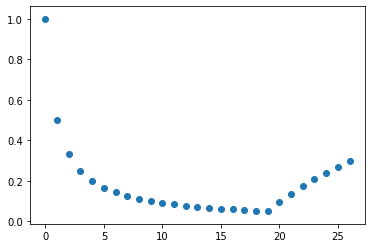

In [14]:

for dtime in testing_dates_01:
    #Defines the time window to do analisys
    order_datetime = dtime
    start_datetime = order_datetime - relativedelta(days=6)
    end_datetime = order_datetime + relativedelta(days=1.5)

    df_sim_results = simulation(order_datetime, start_datetime, end_datetime)
    
    if dtime == testing_dates_01[0]:
        df_sim_results_01 = df_sim_results.copy()
    else:
        df_sim_results_01 = df_sim_results_01.append(df_sim_results).copy()
        
    

In [15]:
#testing_dates
df_sim_results_01

Datetime        Close target_order  target_close  \
0  2022-02-01 09:45:00  4511.609863         BUY2   4537.459961   
1  2022-02-01 10:00:00  4503.939941         BUY2   4530.479980   
0  2022-02-01 10:00:00  4503.939941         BUY2   4530.479980   
1  2022-02-01 10:15:00  4501.950195          BUY   4522.000000   
0  2022-02-01 10:15:00  4501.950195          BUY   4522.000000   
..                 ...          ...          ...           ...   
1  2022-02-15 15:30:00  4459.399902        SELL2   4437.689941   
0  2022-02-15 15:30:00  4459.399902        SELL2   4437.689941   
1  2022-02-15 15:45:00  4470.700195        SELL2   4449.279785   
0  2022-02-15 15:45:00  4470.700195        SELL2   4449.279785   
1  2022-02-16 09:30:00  4449.279785         BUY2   4471.569824   

    target_difference         target_date  target_date_diff  \
0                26.0 2022-02-01 15:15:00             330.0   
1                27.0 2022-02-01 15:00:00             300.0   
0                27.0 2022-02-01 15:00:00             300.0   
1                20.0 2022-02-01 11:00:00              45.0   
0                20.0 2022-02-01 11:00:00              45.0   
..                ...                 ...               ...   
1               -22.0 2022-02-16 09:45:00            1095.0   
0               -22.0 2022-02-16 09:45:00            1095.0   
1               -21.0 2022-02-16 09:30:00            1065.0   
0               -21.0 2022-02-16 09:30:00            1065.0   
1                22.0 2022-02-16 14:15:00             285.0   

   target_order_coded y_pred prediction_order         0         1         2  \
0                  01     01             BUY2  0.290685  0.458113  0.231202   
1                  01     00              BUY  0.392237  0.318113  0.239650   
0                  01     01             BUY2  0.323367  0.450000  0.226633   
1                  00     00              BUY  0.414659  0.350000  0.227579   
0                  00     01             BUY2  0.380782  0.419218  0.190000   
..                ...    ...              ...       ...       ...       ...   
1                  03     03            SELL2  0.040000  0.020000  0.110000   
0                  03     03            SELL2  0.039735  0.020000  0.080000   
1                  03     03            SELL2  0.039735  0.020000  0.130000   
0                  03     03            SELL2  0.020000  0.020000  0.220991   
1                  01     03            SELL2  0.130000  0.020000  0.250000   

           3  max_prob  Model match  
0   0.020000  0.458113     0.333333  
1   0.050000  0.392237     0.333333  
0   0.000000  0.450000     0.260000  
1   0.007762  0.414659     0.260000  
0   0.010000  0.419218     0.346939  
..       ...       ...          ...  
1   0.830000  0.830000     0.344828  
0   0.860265  0.860265     0.321429  
1   0.810265  0.810265     0.321429  
0   0.739009  0.739009     0.296296  
1   0.600000  0.600000     0.296296  

[548 rows x 16 columns]

In [16]:
df_sim_results_01 = df_sim_results_01.reset_index()

In [17]:
# Confusion Matrix

ls_model_matches = []

for i in range(1,len(df_sim_results_01)+1):
    #df_model_preds_01 = df_model_preds[df_model_preds['max_prob']>=0.42].copy()
    df_model_preds_01 = df_sim_results_01.iloc[:i,].copy()


    df_summary = df_model_preds_01.groupby(['target_order','prediction_order'] ).agg(
        orders_quantity = ('max_prob','count'),
        median_time = ('target_date_diff','median')
    )

    df_summary = df_summary.reset_index()

    True_buys = sum(df_summary[(df_summary['target_order'].isin(['BUY','BUY2']))&(df_summary['prediction_order'].isin(['BUY','BUY2']))]['orders_quantity'])
    True_sells = sum(df_summary[(df_summary['target_order'].isin(['SELL','SELL2']))&(df_summary['prediction_order'].isin(['SELL','SELL2']))]['orders_quantity'])
    Total_orders = sum(df_summary['orders_quantity'])

    pp_model_match = (True_buys + True_sells) / Total_orders
    ls_model_matches.append(pp_model_match)

print('% Model match: ', pp_model_match)
df_summary.sort_values(['orders_quantity'],ascending=[False])

% Model match:  0.8284671532846716


target_order prediction_order  orders_quantity  median_time
10         SELL             SELL              126         60.0
15        SELL2            SELL2              122       1200.0
0           BUY              BUY               81         75.0
5          BUY2             BUY2               52       1087.5
14        SELL2             SELL               25       1140.0
8          SELL              BUY               21         75.0
4          BUY2              BUY               20       1110.0
12        SELL2              BUY               20       1215.0
11         SELL            SELL2               17        105.0
2           BUY             SELL               16         82.5
1           BUY             BUY2               11        150.0
7          BUY2            SELL2               11       1185.0
6          BUY2             SELL               10       1155.0
3           BUY            SELL2                7         60.0
13        SELL2             BUY2                7       1395.0
9          SELL             BUY2                2        105.0

(548, 17)
2022-02-01 09:45:00
2022-02-16 09:30:00
% Model match:  0.8284671532846716


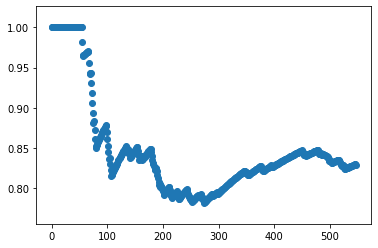

In [18]:
print(df_sim_results_01.shape)
print(min(df_sim_results_01['Datetime']))
print(max(df_sim_results_01['Datetime']))


print('% Model match: ', pp_model_match)

plt.scatter(range(0,len(ls_model_matches)), ls_model_matches)
plt.show()

# Simulation observations

In [20]:
df_sim_results_01['model_match'] = 0

df_sim_results_01.loc[
                (df_sim_results_01['target_order'].isin(['BUY','BUY2']))
                &(df_sim_results_01['prediction_order'].isin(['BUY','BUY2']))
                ,'model_match'] = 1
    
df_sim_results_01.loc[
                (df_sim_results_01['target_order'].isin(['SELL','SELL2']))
                &(df_sim_results_01['prediction_order'].isin(['SELL','SELL2']))
                 ,'model_match'] = 1


print(df_sim_results_01['model_match'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = False))


   index  model_match
0      1          454
1      0           94


In [30]:
df_sim_results_01['target_order_bin'] = 0
df_sim_results_01.loc[(df_sim_results_01['target_order'].isin(['BUY','BUY2'])) ,'target_order_bin'] = 1

print(df_sim_results_01['target_order_bin'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = False))


   index  target_order_bin
1      1               208
0      0               340


In [29]:
df_sim_results_01['date'] = df_sim_results_01['Datetime'].apply(lambda x: x.date())
df_sim_results_01['weekday'] = df_sim_results_01['Datetime'].apply(lambda x: x.weekday())
df_sim_results_01['time'] = df_sim_results_01['Datetime'].apply(lambda x: str(x.hour) + '-' + str(x.minute))

print(df_sim_results_01['weekday'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = False))


   index  weekday
3      4      100
2      3      100
1      2      101
0      1      149
4      0       98


In [31]:
df_datesumm = df_sim_results_01.groupby(['date']).agg(
    total_orders = ('Datetime','count'),
    total_buys = ('target_order_bin','sum'),
    total_matches = ('model_match','sum'),
    ).copy()

df_datesumm = df_datesumm.reset_index()

df_datesumm['pp_model_match'] = df_datesumm['total_matches'] / df_datesumm['total_orders']
df_datesumm['pp_buy'] = df_datesumm['total_buys'] / df_datesumm['total_orders']


df_datesumm

date  total_orders  total_buys  total_matches  pp_model_match  \
0   2022-02-01            49          49             49        1.000000   
1   2022-02-02            50          18             38        0.760000   
2   2022-02-03            50           1             39        0.780000   
3   2022-02-04            50          32             33        0.660000   
4   2022-02-07            49          20             37        0.755102   
5   2022-02-08            50          48             41        0.820000   
6   2022-02-09            50           0             49        0.980000   
7   2022-02-10            50           2             43        0.860000   
8   2022-02-11            50           0             50        1.000000   
9   2022-02-14            49          26             38        0.775510   
10  2022-02-15            50          11             37        0.740000   
11  2022-02-16             1           1              0        0.000000   

      pp_buy  
0   1.000000  
1   0.360000  
2   0.020000  
3   0.640000  
4   0.408163  
5   0.960000  
6   0.000000  
7   0.040000  
8   0.000000  
9   0.530612  
10  0.220000  
11  1.000000

# Prediction managment

In [46]:
df_orders_prediction = df_model_preds[['Datetime','Close','prediction_order','max_prob']]
df_orders_prediction['prediction_time'] = datetime.datetime.now()
df_orders_prediction

Datetime        Close prediction_order  max_prob  \
0 2022-03-04 15:35:00  4306.149902             SELL  0.469888   
1 2022-03-04 15:40:00  4310.640137             SELL  0.503398   
2 2022-03-04 15:45:00  4306.810059             SELL  0.489126   
3 2022-03-04 15:50:00  4325.279785             SELL  0.528151   
4 2022-03-04 15:55:00  4329.359863             SELL  0.512371   
5 2022-03-04 16:00:00  4328.870117             SELL  0.584029   

             prediction_time  
0 2022-03-04 17:42:18.006440  
1 2022-03-04 17:42:18.006440  
2 2022-03-04 17:42:18.006440  
3 2022-03-04 17:42:18.006440  
4 2022-03-04 17:42:18.006440  
5 2022-03-04 17:42:18.006440

In [47]:
# SAVING POINT

#df_orders_prediction.to_pickle(DIR_OUTPUTS + 'df_spx500_5m_preds' + '.pkl')

#print(df_orders_prediction.shape)
#print(datetime.datetime.now())

In [48]:
df_orders_hist_preds = pd.read_pickle(DIR_OUTPUTS + 'df_spx500_5m_preds.pkl')

print(df_orders_hist_preds.shape)
print('\n')

for c in df_orders_hist_preds.columns.tolist():
    print(c)
    
df_orders_hist_preds

(30, 10)


Datetime
prediction_order
max_prob
prediction_time
target_order
target_close
target_difference
target_date
target_date_diff
Close


Datetime prediction_order  max_prob            prediction_time  \
0  2022-03-03 15:35:00            SELL2  0.286311 2022-03-03 18:36:21.412558   
1  2022-03-03 15:40:00            SELL2  0.284221 2022-03-03 18:36:21.412558   
2  2022-03-03 15:45:00            SELL2  0.291060 2022-03-03 18:36:21.412558   
3  2022-03-03 15:50:00              BUY  0.302975 2022-03-03 18:36:21.412558   
4  2022-03-03 15:55:00              BUY  0.310244 2022-03-03 18:36:21.412558   
5  2022-03-03 16:00:00             SELL  0.297535 2022-03-03 18:36:21.412558   
6  2022-03-04 10:25:00              BUY  0.384279 2022-03-04 10:52:59.054411   
7  2022-03-04 10:30:00              BUY  0.387819 2022-03-04 10:52:59.054411   
8  2022-03-04 10:35:00              BUY  0.398371 2022-03-04 10:52:59.054411   
9  2022-03-04 10:40:00              BUY  0.440754 2022-03-04 10:52:59.054411   
10 2022-03-04 10:45:00              BUY  0.413793 2022-03-04 10:52:59.054411   
11 2022-03-04 10:50:43              BUY  0.409562 2022-03-04 10:52:59.054411   
12 2022-03-04 10:50:00              BUY  0.518568 2022-03-04 11:15:25.793930   
13 2022-03-04 10:55:00              BUY  0.480188 2022-03-04 11:15:25.793930   
14 2022-03-04 11:00:00              BUY  0.420440 2022-03-04 11:15:25.793930   
15 2022-03-04 11:05:00              BUY  0.463596 2022-03-04 11:15:25.793930   
16 2022-03-04 11:10:00              BUY  0.399084 2022-03-04 11:15:25.793930   
17 2022-03-04 11:11:13              BUY  0.386298 2022-03-04 11:15:25.793930   
18 2022-03-04 11:15:00              BUY  0.429606 2022-03-04 11:27:40.561271   
19 2022-03-04 11:20:00              BUY  0.429080 2022-03-04 11:27:40.561271   
20 2022-03-04 11:25:15              BUY  0.446693 2022-03-04 11:27:40.561271   
21 2022-03-04 11:25:00              BUY  0.384444 2022-03-04 11:52:56.059541   
22 2022-03-04 11:30:00              BUY  0.360837 2022-03-04 11:52:56.059541   
23 2022-03-04 11:35:00              BUY  0.335505 2022-03-04 11:52:56.059541   
24 2022-03-04 11:40:00              BUY  0.373064 2022-03-04 11:52:56.059541   
25 2022-03-04 11:45:00              BUY  0.362974 2022-03-04 11:52:56.059541   
26 2022-03-04 11:50:29             SELL  0.351542 2022-03-04 11:52:56.059541   
27 2022-03-04 11:50:00             SELL  0.382408 2022-03-04 12:02:48.571699   
28 2022-03-04 11:55:00             SELL  0.443077 2022-03-04 12:02:48.571699   
29 2022-03-04 12:00:23             SELL  0.416878 2022-03-04 12:02:48.571699   

   target_order  target_close  target_difference         target_date  \
0         SELL2   4321.549805              -38.0 2022-03-04 09:30:00   
1         SELL2   4321.549805              -29.0 2022-03-04 09:30:00   
2         SELL2   4321.549805              -32.0 2022-03-04 09:30:00   
3         SELL2   4321.549805              -37.0 2022-03-04 09:30:00   
4         SELL2   4321.549805              -42.0 2022-03-04 09:30:00   
5           NaN           NaN                NaN                 NaT   
6          BUY2   4324.870117               21.0 2022-03-04 12:55:00   
7          BUY2   4318.290039               20.0 2022-03-04 12:15:00   
8          BUY2   4324.870117               21.0 2022-03-04 12:55:00   
9          BUY2   4318.290039               21.0 2022-03-04 12:15:00   
10         BUY2   4316.520020               23.0 2022-03-04 12:10:00   
11          NaN           NaN                NaN                 NaT   
12         BUY2   4316.520020               20.0 2022-03-04 12:10:00   
13          BUY   4316.520020               26.0 2022-03-04 12:10:00   
14          BUY   4316.520020               27.0 2022-03-04 12:10:00   
15          BUY   4316.520020               27.0 2022-03-04 12:10:00   
16          BUY   4316.520020               28.0 2022-03-04 12:10:00   
17          NaN           NaN                NaN                 NaT   
18          BUY   4316.520020               21.0 2022-03-04 12:10:00   
19          BUY   4316.520020               21.0 2022-03-04 12:10:00   
20          NaN      

In [49]:
# Appends new predictions to the historical prediction storage

df_orders_hist_preds_01 = df_orders_hist_preds.append(df_orders_prediction).copy()
df_orders_hist_preds_01 = df_orders_hist_preds_01.reset_index(drop=True)

# REMOVES DUPLICATED DATA BY THE PREDICTION DATE

df_orders_hist_preds_01['id_pred'] = df_orders_hist_preds_01.sort_values(['Datetime','prediction_time'],\
                        ascending=[True,True]) \
                        .groupby(['Datetime']) \
                        .cumcount() + 1

df_orders_hist_preds_01 = df_orders_hist_preds_01[df_orders_hist_preds_01['id_pred']==1].copy()
df_orders_hist_preds_01 = df_orders_hist_preds_01.drop(columns=['id_pred'])
df_orders_hist_preds_01 = df_orders_hist_preds_01.reset_index(drop=True)


df_orders_hist_preds_01

Datetime prediction_order  max_prob            prediction_time  \
0  2022-03-03 15:35:00            SELL2  0.286311 2022-03-03 18:36:21.412558   
1  2022-03-03 15:40:00            SELL2  0.284221 2022-03-03 18:36:21.412558   
2  2022-03-03 15:45:00            SELL2  0.291060 2022-03-03 18:36:21.412558   
3  2022-03-03 15:50:00              BUY  0.302975 2022-03-03 18:36:21.412558   
4  2022-03-03 15:55:00              BUY  0.310244 2022-03-03 18:36:21.412558   
5  2022-03-03 16:00:00             SELL  0.297535 2022-03-03 18:36:21.412558   
6  2022-03-04 10:25:00              BUY  0.384279 2022-03-04 10:52:59.054411   
7  2022-03-04 10:30:00              BUY  0.387819 2022-03-04 10:52:59.054411   
8  2022-03-04 10:35:00              BUY  0.398371 2022-03-04 10:52:59.054411   
9  2022-03-04 10:40:00              BUY  0.440754 2022-03-04 10:52:59.054411   
10 2022-03-04 10:45:00              BUY  0.413793 2022-03-04 10:52:59.054411   
11 2022-03-04 10:50:43              BUY  0.409562 2022-03-04 10:52:59.054411   
12 2022-03-04 10:50:00              BUY  0.518568 2022-03-04 11:15:25.793930   
13 2022-03-04 10:55:00              BUY  0.480188 2022-03-04 11:15:25.793930   
14 2022-03-04 11:00:00              BUY  0.420440 2022-03-04 11:15:25.793930   
15 2022-03-04 11:05:00              BUY  0.463596 2022-03-04 11:15:25.793930   
16 2022-03-04 11:10:00              BUY  0.399084 2022-03-04 11:15:25.793930   
17 2022-03-04 11:11:13              BUY  0.386298 2022-03-04 11:15:25.793930   
18 2022-03-04 11:15:00              BUY  0.429606 2022-03-04 11:27:40.561271   
19 2022-03-04 11:20:00              BUY  0.429080 2022-03-04 11:27:40.561271   
20 2022-03-04 11:25:15              BUY  0.446693 2022-03-04 11:27:40.561271   
21 2022-03-04 11:25:00              BUY  0.384444 2022-03-04 11:52:56.059541   
22 2022-03-04 11:30:00              BUY  0.360837 2022-03-04 11:52:56.059541   
23 2022-03-04 11:35:00              BUY  0.335505 2022-03-04 11:52:56.059541   
24 2022-03-04 11:40:00              BUY  0.373064 2022-03-04 11:52:56.059541   
25 2022-03-04 11:45:00              BUY  0.362974 2022-03-04 11:52:56.059541   
26 2022-03-04 11:50:29             SELL  0.351542 2022-03-04 11:52:56.059541   
27 2022-03-04 11:50:00             SELL  0.382408 2022-03-04 12:02:48.571699   
28 2022-03-04 11:55:00             SELL  0.443077 2022-03-04 12:02:48.571699   
29 2022-03-04 12:00:23             SELL  0.416878 2022-03-04 12:02:48.571699   
30 2022-03-04 15:35:00             SELL  0.469888 2022-03-04 17:42:18.006440   
31 2022-03-04 15:40:00             SELL  0.503398 2022-03-04 17:42:18.006440   
32 2022-03-04 15:45:00             SELL  0.489126 2022-03-04 17:42:18.006440   
33 2022-03-04 15:50:00             SELL  0.528151 2022-03-04 17:42:18.006440   
34 2022-03-04 15:55:00             SELL  0.512371 2022-03-04 17:42:18.006440   
35 2022-03-04 16:00:00             SELL  0.584029 2022-03-04 17:42:18.006440   

   target_order  target_close  target_difference         target_date  \
0         SELL2   4321.549805              -38.0 2022-03-04 09:30:00   
1         SELL2   4321.549805              -29.0 2022-03-04 09:30:00   
2         SELL2   4321.549805              -32.0 2022-03-04 09:30:00   
3         SELL2   4321.549805              -37.0 2022-03-04 09:30:00   
4         SELL2   4321.549805              -42.0 2022-03-04 09:30:00   
5           NaN           NaN                NaN                 NaT   
6          BUY2   4324.870117               21.0 2022-03-04 12:55:00   
7          BUY2   4318.290039               20.0 2022-03-04 12:15:00   
8          BUY2   4324.870117               21.0 2022-03-04 12:55:00   
9          BUY2   4318.290039               21.0 2022-03-04 12:15:00   
10         BUY2   4316.520020               23.0 2022-03-04 12:10:00   
11          NaN           NaN                NaN                 NaT   
12         BUY2   4316.520020               20.0 2022-03-04 12:10:00   
13          BUY   4316.520020               2

In [50]:
# Imports the last information data of trades

df_analysis_100 = pd.read_pickle(DIR_OUTPUTS + 'df_spx500_5m_s1.pkl')

print(df_analysis_100.shape)
print('\n')

for c in df_analysis_100.columns.tolist():
    print(c)

(893, 78)


Datetime
slope_close_0
slope_close_1
slope_close_2
slope_close_3
ss80_close_8
ss80_close_7
ss80_close_6
ss80_close_5
ss80_close_4
ss80_close_3
ss80_close_2
ss80_close_1
ss80_close_c1
ss80_close_c2
ss80_close_c3
ss160_close_c1
ss160_close_c2
ss160_close_c3
slope_macdh_0
slope_macdh_1
slope_macdh_2
slope_macdh_3
ss80_macdh_8
ss80_macdh_7
ss80_macdh_6
ss80_macdh_5
ss80_macdh_4
ss80_macdh_3
ss80_macdh_2
ss80_macdh_1
ss80_macdh_c1
ss80_macdh_c2
ss80_macdh_c3
ss160_macdh_c1
ss160_macdh_c2
ss160_macdh_c3
slope_macd_0
slope_macd_1
slope_macd_2
slope_macd_3
ss80_macd_8
ss80_macd_7
ss80_macd_6
ss80_macd_5
ss80_macd_4
ss80_macd_3
ss80_macd_2
ss80_macd_1
ss80_macd_c1
ss80_macd_c2
ss80_macd_c3
slope_vols_0
slope_vols_1
slope_vols_2
slope_vols_3
ss20_vols_8
ss20_vols_7
ss20_vols_6
ss20_vols_5
ss20_vols_4
ss20_vols_3
ss20_vols_2
ss20_vols_1
ss20_vols_c1
ss20_vols_c2
ss20_vols_c3
ss80_vols_c1
ss80_vols_c2
ss80_vols_c3
date
Close
target_order
target_order_bin
target_close
target_difference


In [51]:
#Jons the prediction, with trade info

df_orders_hist_preds_02 = pd.merge(df_orders_hist_preds_01,
                                  df_analysis_100[ls_target_info],
                                  on=['Datetime'],
                                  how='left').copy()


#Fix duplicated columns

df_input = df_orders_hist_preds_02.copy()
ls_ttcols = df_input.columns.tolist()

ls_duplcols = [x.replace('_x','') for x in ls_ttcols if '_x' in x]
ls_duplcols

for c in ls_duplcols:
    df_input[c] = df_input[c+'_x']
    df_input.loc[df_input[c].isnull(),c] = df_input[c+'_y']
    df_input.loc[df_input[c].isin(['NULL']),c] = df_input[c+'_y']
    df_input = df_input.drop(columns=[c+'_x',c+'_y'])

print(df_input.columns.tolist())

df_orders_hist_preds_03 = df_input.copy()

print(df_orders_hist_preds_03.shape)
df_orders_hist_preds_03

['Datetime', 'prediction_order', 'max_prob', 'prediction_time', 'target_order', 'target_close', 'target_difference', 'target_date', 'target_date_diff', 'Close']
(36, 10)


Datetime prediction_order  max_prob            prediction_time  \
0  2022-03-03 15:35:00            SELL2  0.286311 2022-03-03 18:36:21.412558   
1  2022-03-03 15:40:00            SELL2  0.284221 2022-03-03 18:36:21.412558   
2  2022-03-03 15:45:00            SELL2  0.291060 2022-03-03 18:36:21.412558   
3  2022-03-03 15:50:00              BUY  0.302975 2022-03-03 18:36:21.412558   
4  2022-03-03 15:55:00              BUY  0.310244 2022-03-03 18:36:21.412558   
5  2022-03-03 16:00:00             SELL  0.297535 2022-03-03 18:36:21.412558   
6  2022-03-04 10:25:00              BUY  0.384279 2022-03-04 10:52:59.054411   
7  2022-03-04 10:30:00              BUY  0.387819 2022-03-04 10:52:59.054411   
8  2022-03-04 10:35:00              BUY  0.398371 2022-03-04 10:52:59.054411   
9  2022-03-04 10:40:00              BUY  0.440754 2022-03-04 10:52:59.054411   
10 2022-03-04 10:45:00              BUY  0.413793 2022-03-04 10:52:59.054411   
11 2022-03-04 10:50:43              BUY  0.409562 2022-03-04 10:52:59.054411   
12 2022-03-04 10:50:00              BUY  0.518568 2022-03-04 11:15:25.793930   
13 2022-03-04 10:55:00              BUY  0.480188 2022-03-04 11:15:25.793930   
14 2022-03-04 11:00:00              BUY  0.420440 2022-03-04 11:15:25.793930   
15 2022-03-04 11:05:00              BUY  0.463596 2022-03-04 11:15:25.793930   
16 2022-03-04 11:10:00              BUY  0.399084 2022-03-04 11:15:25.793930   
17 2022-03-04 11:11:13              BUY  0.386298 2022-03-04 11:15:25.793930   
18 2022-03-04 11:15:00              BUY  0.429606 2022-03-04 11:27:40.561271   
19 2022-03-04 11:20:00              BUY  0.429080 2022-03-04 11:27:40.561271   
20 2022-03-04 11:25:15              BUY  0.446693 2022-03-04 11:27:40.561271   
21 2022-03-04 11:25:00              BUY  0.384444 2022-03-04 11:52:56.059541   
22 2022-03-04 11:30:00              BUY  0.360837 2022-03-04 11:52:56.059541   
23 2022-03-04 11:35:00              BUY  0.335505 2022-03-04 11:52:56.059541   
24 2022-03-04 11:40:00              BUY  0.373064 2022-03-04 11:52:56.059541   
25 2022-03-04 11:45:00              BUY  0.362974 2022-03-04 11:52:56.059541   
26 2022-03-04 11:50:29             SELL  0.351542 2022-03-04 11:52:56.059541   
27 2022-03-04 11:50:00             SELL  0.382408 2022-03-04 12:02:48.571699   
28 2022-03-04 11:55:00             SELL  0.443077 2022-03-04 12:02:48.571699   
29 2022-03-04 12:00:23             SELL  0.416878 2022-03-04 12:02:48.571699   
30 2022-03-04 15:35:00             SELL  0.469888 2022-03-04 17:42:18.006440   
31 2022-03-04 15:40:00             SELL  0.503398 2022-03-04 17:42:18.006440   
32 2022-03-04 15:45:00             SELL  0.489126 2022-03-04 17:42:18.006440   
33 2022-03-04 15:50:00             SELL  0.528151 2022-03-04 17:42:18.006440   
34 2022-03-04 15:55:00             SELL  0.512371 2022-03-04 17:42:18.006440   
35 2022-03-04 16:00:00             SELL  0.584029 2022-03-04 17:42:18.006440   

   target_order  target_close  target_difference         target_date  \
0         SELL2   4321.549805              -38.0 2022-03-04 09:30:00   
1         SELL2   4321.549805              -29.0 2022-03-04 09:30:00   
2         SELL2   4321.549805              -32.0 2022-03-04 09:30:00   
3         SELL2   4321.549805              -37.0 2022-03-04 09:30:00   
4         SELL2   4321.549805              -42.0 2022-03-04 09:30:00   
5           NaN           NaN                NaN                 NaT   
6          BUY2   4324.870117               21.0 2022-03-04 12:55:00   
7          BUY2   4318.290039               20.0 2022-03-04 12:15:00   
8          BUY2   4324.870117               21.0 2022-03-04 12:55:00   
9          BUY2   4318.290039               21.0 2022-03-04 12:15:00   
10         BUY2   4316.520020               23.0 2022-03-04 12:10:00   
11          NaN           NaN                NaN                 NaT   
12         BUY2   4316.520020               20.0 2022-03-04 12:10:00   
13          BUY   4316.520020               2

In [52]:
# SAVING POINT

df_orders_hist_preds_03.to_pickle(DIR_OUTPUTS + 'df_spx500_5m_preds' + '.pkl')

print(df_orders_hist_preds_03.shape)
print(datetime.datetime.now())

(36, 10)
2022-03-04 17:42:18.835929


In [53]:
# Confusion Matrix

df_model_preds_03 = df_orders_hist_preds_03[df_orders_hist_preds_03['prediction_time']>'2022-03-03 18:36:21.412558'].copy()

# Confusion Matrix


ls_model_matches = []

for i in range(1,len(df_model_preds_03)+1):
    #df_model_preds_01 = df_model_preds[df_model_preds['max_prob']>=0.42].copy()
    df_model_preds_01 = df_model_preds_03.iloc[:i,].copy()


    df_summary = df_model_preds_01.groupby(['target_order','prediction_order'] ).agg(
        orders_quantity = ('max_prob','count'),
        median_time = ('target_date_diff','median')
    )

    df_summary = df_summary.reset_index()

    True_buys = sum(df_summary[(df_summary['target_order'].isin(['BUY','BUY2']))&(df_summary['prediction_order'].isin(['BUY','BUY2']))]['orders_quantity'])
    True_sells = sum(df_summary[(df_summary['target_order'].isin(['SELL','SELL2']))&(df_summary['prediction_order'].isin(['SELL','SELL2']))]['orders_quantity'])
    Total_orders = sum(df_summary['orders_quantity'])

    pp_model_match = (True_buys + True_sells) / Total_orders
    ls_model_matches.append(pp_model_match)

print('% Model match: ', pp_model_match)
df_summary.sort_values(['orders_quantity'],ascending=[False])

% Model match:  0.68


target_order prediction_order  orders_quantity  median_time
0          BUY              BUY               10         62.5
2         BUY2              BUY                7         95.0
1          BUY             SELL                4         20.0
3         NULL             SELL                4          NaN

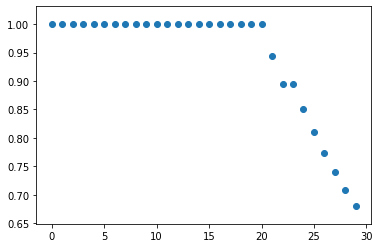

In [54]:
plt.scatter(range(0,len(ls_model_matches)), ls_model_matches)
plt.show()

In [55]:
df_model_preds_03

Datetime prediction_order  max_prob            prediction_time  \
6  2022-03-04 10:25:00              BUY  0.384279 2022-03-04 10:52:59.054411   
7  2022-03-04 10:30:00              BUY  0.387819 2022-03-04 10:52:59.054411   
8  2022-03-04 10:35:00              BUY  0.398371 2022-03-04 10:52:59.054411   
9  2022-03-04 10:40:00              BUY  0.440754 2022-03-04 10:52:59.054411   
10 2022-03-04 10:45:00              BUY  0.413793 2022-03-04 10:52:59.054411   
11 2022-03-04 10:50:43              BUY  0.409562 2022-03-04 10:52:59.054411   
12 2022-03-04 10:50:00              BUY  0.518568 2022-03-04 11:15:25.793930   
13 2022-03-04 10:55:00              BUY  0.480188 2022-03-04 11:15:25.793930   
14 2022-03-04 11:00:00              BUY  0.420440 2022-03-04 11:15:25.793930   
15 2022-03-04 11:05:00              BUY  0.463596 2022-03-04 11:15:25.793930   
16 2022-03-04 11:10:00              BUY  0.399084 2022-03-04 11:15:25.793930   
17 2022-03-04 11:11:13              BUY  0.386298 2022-03-04 11:15:25.793930   
18 2022-03-04 11:15:00              BUY  0.429606 2022-03-04 11:27:40.561271   
19 2022-03-04 11:20:00              BUY  0.429080 2022-03-04 11:27:40.561271   
20 2022-03-04 11:25:15              BUY  0.446693 2022-03-04 11:27:40.561271   
21 2022-03-04 11:25:00              BUY  0.384444 2022-03-04 11:52:56.059541   
22 2022-03-04 11:30:00              BUY  0.360837 2022-03-04 11:52:56.059541   
23 2022-03-04 11:35:00              BUY  0.335505 2022-03-04 11:52:56.059541   
24 2022-03-04 11:40:00              BUY  0.373064 2022-03-04 11:52:56.059541   
25 2022-03-04 11:45:00              BUY  0.362974 2022-03-04 11:52:56.059541   
26 2022-03-04 11:50:29             SELL  0.351542 2022-03-04 11:52:56.059541   
27 2022-03-04 11:50:00             SELL  0.382408 2022-03-04 12:02:48.571699   
28 2022-03-04 11:55:00             SELL  0.443077 2022-03-04 12:02:48.571699   
29 2022-03-04 12:00:23             SELL  0.416878 2022-03-04 12:02:48.571699   
30 2022-03-04 15:35:00             SELL  0.469888 2022-03-04 17:42:18.006440   
31 2022-03-04 15:40:00             SELL  0.503398 2022-03-04 17:42:18.006440   
32 2022-03-04 15:45:00             SELL  0.489126 2022-03-04 17:42:18.006440   
33 2022-03-04 15:50:00             SELL  0.528151 2022-03-04 17:42:18.006440   
34 2022-03-04 15:55:00             SELL  0.512371 2022-03-04 17:42:18.006440   
35 2022-03-04 16:00:00             SELL  0.584029 2022-03-04 17:42:18.006440   

   target_order  target_close  target_difference         target_date  \
6          BUY2   4324.870117               21.0 2022-03-04 12:55:00   
7          BUY2   4318.290039               20.0 2022-03-04 12:15:00   
8          BUY2   4324.870117               21.0 2022-03-04 12:55:00   
9          BUY2   4318.290039               21.0 2022-03-04 12:15:00   
10         BUY2   4316.520020               23.0 2022-03-04 12:10:00   
11          NaN           NaN                NaN                 NaT   
12         BUY2   4316.520020               20.0 2022-03-04 12:10:00   
13          BUY   4316.520020               26.0 2022-03-04 12:10:00   
14          BUY   4316.520020               27.0 2022-03-04 12:10:00   
15          BUY   4316.520020               27.0 2022-03-04 12:10:00   
16          BUY   4316.520020               28.0 2022-03-04 12:10:00   
17          NaN           NaN                NaN                 NaT   
18          BUY   4316.520020               21.0 2022-03-04 12:10:00   
19          BUY   4316.520020               21.0 2022-03-04 12:10:00   
20          NaN           NaN                NaN                 NaT   
21          BUY   4318.290039               22.0 2022-03-04 12:15:00   
22          BUY   4316.520020               24.0 2022-03-04 12:10:00   
23         BUY2   4324.870117               24.0 2022-03-04 12:55:00   
24          BUY   4324.870117               24.0 2022-03-04 12:55:00   
25          BUY   4335.660156               31.0 2022-03-04 13:00:00   
26          NaN      

# Data observation

In [87]:
# Hold Predictions table

# Selectiong winner model
#winner_model = lgbm_search
winner_model = rf_search
#winner_model = ex_search
#winner_model = clf

X_work = X_train
y_work = y_train

ls_target_info = ['Datetime','Close','target_order','target_close','target_difference','target_date','target_date_diff']

df_datainfo = df_analysis_02a.iloc[X_work.index,:]
df_datainfo = df_datainfo[ls_target_info]
df_datainfo = df_datainfo.reset_index(drop=True)

#########################################################################
y_prob = winner_model.predict_proba(X_work)
print(y_prob.shape)

df_model_probs = pd.DataFrame(y_prob)
df_model_probs = df_model_probs.reset_index(drop=True)
#########################################################################


#########################################################################
y_pred = winner_model.predict(X_work)
print(y_pred.shape)

df_model_preds = df_datainfo
df_model_preds = df_model_preds.reset_index(drop=True)
#########################################################################


#######################################################################################################
df_model_preds['target_order_coded'] = y_work.reset_index(drop=True)
df_model_preds.loc[df_model_preds['target_order_coded'].isnull(),'target_order_coded']='NULL'

df_model_preds['y_pred'] = y_pred

dc_renamecols = {
    'target_order_coded': 'y_pred',
    'target_order': 'prediction_order',
    }

df_prediction_coded = df_target_coded.rename(columns=dc_renamecols)


df_model_preds = pd.merge(df_model_preds,
                      df_prediction_coded[['y_pred','prediction_order']],
                      on = ['y_pred'],
                      how='left'
                      ).copy()

df_model_preds = pd.concat([df_model_preds,df_model_probs],axis=1)

df_model_preds['max_prob'] = df_model_preds[[0,1,2,3]].max(axis=1)
#######################################################################################################


df_model_preds

(819, 4)
(819,)


Datetime        Close target_order  target_close  \
0   2022-02-16 13:10:00  4439.589844          BUY   4471.140137   
1   2022-02-16 13:15:00  4439.779785          BUY   4471.140137   
2   2022-02-16 13:20:00  4441.259766          BUY   4471.140137   
3   2022-02-16 13:25:00  4440.500000          BUY   4471.140137   
4   2022-02-16 13:30:00  4438.470215          BUY   4471.140137   
..                  ...          ...          ...           ...   
814 2022-03-04 09:30:00  4321.549805         SELL   4296.459961   
815 2022-03-04 09:35:00  4322.009766         SELL   4296.459961   
816 2022-03-04 09:45:00  4302.220215          BUY   4324.250000   
817 2022-03-04 09:55:00  4324.250000         SELL   4296.459961   
818 2022-03-04 10:00:00  4319.049805         SELL   4296.459961   

     target_difference         target_date  target_date_diff  \
0                 32.0 2022-02-16 14:20:00              70.0   
1                 31.0 2022-02-16 14:20:00              65.0   
2                 30.0 2022-02-16 14:20:00              60.0   
3                 31.0 2022-02-16 14:20:00              55.0   
4                 33.0 2022-02-16 14:20:00              50.0   
..                 ...                 ...               ...   
814              -25.0 2022-03-04 10:10:00              40.0   
815              -26.0 2022-03-04 10:10:00              35.0   
816               22.0 2022-03-04 09:55:00              10.0   
817              -28.0 2022-03-04 10:10:00              15.0   
818              -23.0 2022-03-04 10:10:00              10.0   

    target_order_coded y_pred prediction_order         0         1         2  \
0                   00     00              BUY  0.474755  0.027200  0.328411   
1                   00     00              BUY  0.565373  0.024833  0.257126   
2                   00     00              BUY  0.656572  0.031447  0.193036   
3                   00     00              BUY  0.706619  0.042715  0.175039   
4                   00     00              BUY  0.706162  0.044205  0.174261   
..                 ...    ...              ...       ...       ...       ...   
814                 03     04            SELL2  0.239810  0.124801  0.296800   
815                 03     03             SELL  0.267511  0.134739  0.350478   
816                 00     00              BUY  0.523650  0.098081  0.225345   
817                 03     03             SELL  0.304129  0.098653  0.363876   
818                 03     03             SELL  0.269379  0.062234  0.402805   

            3  max_prob  
0    0.169634  0.474755  
1    0.152668  0.565373  
2    0.118945  0.656572  
3    0.075626  0.706619  
4    0.075372  0.706162  
..        ...       ...  
814  0.338590  0.338590  
815  0.247272  0.350478  
816  0.152924  0.523650  
817  0.233342  0.363876  
818  0.265582  0.402805  

[819 rows x 15 columns]

In [91]:
df_model_preds[ (df_model_preds['Datetime']>=datetime.datetime(2022,3,3,15,30))]
                #&(df_model_preds['Datetime']<=datetime.datetime(2022,3,2,16))]

Datetime        Close target_order  target_close  \
808 2022-03-03 15:30:00  4357.140137        SELL2   4321.549805   
809 2022-03-03 15:35:00  4359.890137        SELL2   4321.549805   
810 2022-03-03 15:40:00  4350.759766        SELL2   4321.549805   
811 2022-03-03 15:45:00  4353.180176        SELL2   4321.549805   
812 2022-03-03 15:50:00  4358.830078        SELL2   4321.549805   
813 2022-03-03 15:55:00  4363.740234        SELL2   4321.549805   
814 2022-03-04 09:30:00  4321.549805         SELL   4296.459961   
815 2022-03-04 09:35:00  4322.009766         SELL   4296.459961   
816 2022-03-04 09:45:00  4302.220215          BUY   4324.250000   
817 2022-03-04 09:55:00  4324.250000         SELL   4296.459961   
818 2022-03-04 10:00:00  4319.049805         SELL   4296.459961   

     target_difference         target_date  target_date_diff  \
808              -36.0 2022-03-04 09:30:00            1080.0   
809              -38.0 2022-03-04 09:30:00            1075.0   
810              -29.0 2022-03-04 09:30:00            1070.0   
811              -32.0 2022-03-04 09:30:00            1065.0   
812              -37.0 2022-03-04 09:30:00            1060.0   
813              -42.0 2022-03-04 09:30:00            1055.0   
814              -25.0 2022-03-04 10:10:00              40.0   
815              -26.0 2022-03-04 10:10:00              35.0   
816               22.0 2022-03-04 09:55:00              10.0   
817              -28.0 2022-03-04 10:10:00              15.0   
818              -23.0 2022-03-04 10:10:00              10.0   

    target_order_coded y_pred prediction_order         0         1         2  \
808                 04     04            SELL2  0.213711  0.051033  0.185421   
809                 04     04            SELL2  0.211262  0.063377  0.170429   
810                 04     04            SELL2  0.207944  0.085463  0.166433   
811                 04     04            SELL2  0.207809  0.115534  0.153641   
812                 04     04            SELL2  0.210030  0.047585  0.239109   
813                 04     04            SELL2  0.235581  0.044919  0.227987   
814                 03     04            SELL2  0.239810  0.124801  0.296800   
815                 03     03             SELL  0.267511  0.134739  0.350478   
816                 00     00              BUY  0.523650  0.098081  0.225345   
817                 03     03             SELL  0.304129  0.098653  0.363876   
818                 03     03             SELL  0.269379  0.062234  0.402805   

            3  max_prob  
808  0.549834  0.549834  
809  0.554932  0.554932  
810  0.540160  0.540160  
811  0.523016  0.523016  
812  0.503277  0.503277  
813  0.491512  0.491512  
814  0.338590  0.338590  
815  0.247272  0.350478  
816  0.152924  0.523650  
817  0.233342  0.363876  
818  0.265582  0.402805